# Detection Layer - 3-Label Classification

In [7]:
# Configuration Section - Easy experiment control
CONFIG = {
    'RANDOM_STATES': 10,           # Number of random states to test
    'ENABLE_CLASSICAL': True,       # Enable classical classifiers
    'ENABLE_STATIC': True,          # Enable static/ensemble classifiers  
    'ENABLE_DES': True,             # Enable Dynamic Ensemble Selection
    'ENABLE_HYPEROPT': True,        # Enable hyperparameter optimization - ENABLED
    'TOP_FEATURES_COUNT': 50,       # Number of top features to select
    'SAVE_PLOTS': True,             # Save plots as SVG files
    'VERBOSE': True                 # Verbose output
}

print("Experiment Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Experiment Configuration:
  RANDOM_STATES: 10
  ENABLE_CLASSICAL: True
  ENABLE_STATIC: True
  ENABLE_DES: True
  ENABLE_HYPEROPT: True
  TOP_FEATURES_COUNT: 50
  SAVE_PLOTS: True
  VERBOSE: True


In [8]:
# Enhanced imports with better error handling
%pip install optuna -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna

# Install and import DESlib
!pip install deslib -q
from deslib.dcs import APosteriori
from deslib.des import KNORAE, KNORAU, KNOP, DESMI

from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier

# Install and import CatBoost
!pip install catboost -q
from catboost import CatBoostClassifier

# Note: LightGBM commented out as requested
# from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np
from scipy.stats import friedmanchisquare, rankdata
import shap

!pip install scikit-posthocs -q
import scikit_posthocs as sp

from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier

!pip install scikit-optimize -q
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
from deslib.des.knop import KNOP
from deslib.des.meta_des import METADES
from deslib.des.des_knn import DESKNN
from deslib.des.des_p import DESP
from sklearn.model_selection import RandomizedSearchCV

# Set plot style for better visualization
plt.style.use('default')
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


### Data Preparation and Analysis
Enhanced data loading with comprehensive statistics

In [9]:
# Enhanced dataset loading with comprehensive analysis
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('./3labelv4Classification.csv')

print("="*60)
print("DATASET INFORMATION")
print("="*60)
initial_df.info()
print(f"\nDataset shape: {initial_df.shape}")
print(f"Memory usage: {initial_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst few rows:")
display(initial_df.head())

# Enhanced target analysis
target_candidates = ['BCaseControlStatus', 'label_encoded']
for col in target_candidates:
    if col in initial_df.columns:
        print(f"\nValue counts for {col}:")
        print(initial_df[col].value_counts())

# Missing values analysis
print(f"\nMissing Values Analysis:")
print("-" * 40)
missing_info = initial_df.isnull().sum()
missing_percent = (missing_info / len(initial_df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_info,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Percent', ascending=False)

print(f"Columns with missing values: {(missing_info > 0).sum()}")
print(f"Total missing values: {missing_info.sum()}")
print("\nTop 10 columns with most missing values:")
print(missing_df.head(10))

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Columns: 134 entries, PtID to MULTIMODAL_COMPLETENESS
dtypes: bool(4), float64(83), int64(12), object(35)
memory usage: 201.0+ KB

Dataset shape: (197, 134)
Memory usage: 0.57 MB

First few rows:


,PtID,DealHypoEp,UndertreatHypo,HighBGDamage,FreqHypoDamage,DangersHighBG,HighBGLevTakeAction,LowBGLevTakeAction,PtCurrA1cGoal,label_encoded,...,medconditions2_word_count,medications2_count,medications2_unique_values,medications2_text_length,medications2_word_count,HAS_TABULAR_DATA,HAS_TEXT_DATA,HAS_TIMESERIES_DATA,HAS_HEALTH_SURVEY,MULTIMODAL_COMPLETENESS
0,1,Disagree,Disagree,Disagree,Agree,Disagree,170.0,80.0,8.0,0,...,137.0,1.0,11.0,723.0,138.0,True,True,True,True,1.0
1,2,Neutral,Disagree,Disagree,Neutral,Agree,175.0,80.0,6.8,1,...,149.0,1.0,11.0,783.0,148.0,True,True,True,True,1.0
2,3,Disagree,Disagree,Disagree,Agree,Disagree,200.0,70.0,7.9,1,...,147.0,1.0,11.0,867.0,162.0,True,True,True,True,1.0
3,4,Disagree,Agree,Agree,Agree,Agree,140.0,65.0,5.4,1,...,146.0,1.0,11.0,867.0,162.0,True,True,True,True,1.0
4,5,Disagree,Disagree,Agree,Agree,Disagree,100.0,70.0,5.0,1,...,171.0,1.0,11.0,998.0,185.0,True,True,True,True,1.0



Value counts for BCaseControlStatus:
Control    99
Case       98
Name: BCaseControlStatus, dtype: int64

Value counts for label_encoded:
1    99
0    98
Name: label_encoded, dtype: int64

Missing Values Analysis:
----------------------------------------
Columns with missing values: 52
Total missing values: 244

Top 10 columns with most missing values:
                               Missing_Count  Missing_Percent
LastFoodIntakeCarbs_BMedChart             46        23.350254
EduLevel_lifestyle                        43        21.827411
Bel70PastMonWSymp_unaware                 32        16.243655
SymbDigOTotCorr_BTOTSCORE                  8         4.060914
SymbDigONumErr_BTOTSCORE                   8         4.060914
LastFoodIntakeHrs_BMedChart                7         3.553299
SymbDigWNumErr_BTOTSCORE                   6         3.045685
TrailMakBTotTime_BTOTSCORE                 6         3.045685
TrailMakBNumErr_BTOTSCORE                  6         3.045685
SymbDigWTotCorr_BTOTSCORE

In [10]:
# Identify the target column - let's assume it's BCaseControlStatus based on the data structure
TARGET_COLUMN = 'BCaseControlStatus'  # Update this if your target is different

# Remove potential data leakage columns - these lion
LEAKAGE_COLUMNS = [ 'PtID',  # Patient ID should not be used as a feature
    'label_encoded',  # This appears to be another encoding of the target
    'label_encoded_BMedChart', 
    'label_encoded_BSample',
    'label_encoded_BTOTSCORE',
    'label_encoded_depression',
    'label_encoded_fear',
    'label_encoded_lifestyle',
    'label_encoded_MOCA',
    'label_encoded_unaware'
]

# All categorical features except for target and leakage columns
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
if TARGET_COLUMN in categorical_features:
    categorical_features.remove(TARGET_COLUMN)

# Remove leakage columns from categorical features
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in categorical_features:
        categorical_features.remove(leak_col)

print(f"Target column: {TARGET_COLUMN}")
print(f"Removed leakage columns: {LEAKAGE_COLUMNS}")
print(f"Number of categorical features: {len(categorical_features)}")
print(f"Number of numerical features: {len(num_cols)}")

# Label Encode all categorical features, but keep missing values
le_initial_df = initial_df.copy()

# Remove leakage columns entirely
for leak_col in LEAKAGE_COLUMNS:
    if leak_col in le_initial_df.columns:
        le_initial_df = le_initial_df.drop(leak_col, axis=1)
        print(f"Removed leakage column: {leak_col}")

dropped_labels = le_initial_df[TARGET_COLUMN]
le_initial_df = le_initial_df.drop(TARGET_COLUMN, axis=1)

for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')
        
        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])
        
        missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
        
        le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)

le_initial_df = pd.concat([le_initial_df, dropped_labels], axis=1)

Target column: BCaseControlStatus
Removed leakage columns: ['PtID', 'label_encoded', 'label_encoded_BMedChart', 'label_encoded_BSample', 'label_encoded_BTOTSCORE', 'label_encoded_depression', 'label_encoded_fear', 'label_encoded_lifestyle', 'label_encoded_MOCA', 'label_encoded_unaware']
Number of categorical features: 34
Number of numerical features: 99
Removed leakage column: PtID
Removed leakage column: label_encoded
Removed leakage column: label_encoded_BMedChart
Removed leakage column: label_encoded_BSample
Removed leakage column: label_encoded_BTOTSCORE
Removed leakage column: label_encoded_depression
Removed leakage column: label_encoded_fear
Removed leakage column: label_encoded_lifestyle
Removed leakage column: label_encoded_MOCA
Removed leakage column: label_encoded_unaware


In [11]:
# Display processed dataset with summary
print("Processed Dataset Summary:")
print(f"Shape: {le_initial_df.shape}")
print(f"Columns: {list(le_initial_df.columns)}")
le_initial_df

Processed Dataset Summary:
Shape: (197, 124)
Columns: ['DealHypoEp', 'UndertreatHypo', 'HighBGDamage', 'FreqHypoDamage', 'DangersHighBG', 'HighBGLevTakeAction', 'LowBGLevTakeAction', 'PtCurrA1cGoal', 'LastFoodIntakeHrs_BMedChart', 'LastFoodIntakeCarbs_BMedChart', 'Weight_mod_BMedChart', 'Height_mod_BMedChart', 'Value_HBA1C_BSample', 'Value_CPEP_BSample', 'Value_CREAS_BSample', 'Value_GLU_BSample', 'Unnamed: 0_BTOTSCORE', 'BGVisit1_BTOTSCORE', 'HopVerbTr1TotCorr_BTOTSCORE', 'HopVerbTr2TotCorr_BTOTSCORE', 'HopVerbTr3TotCorr_BTOTSCORE', 'HopVerbTr4TotCorr_BTOTSCORE', 'HopVerbNumHits_BTOTSCORE', 'HopVerbSemRelErr_BTOTSCORE', 'HopVerbSemUnRelErr_BTOTSCORE', 'HopVerbNumFalPosErr_BTOTSCORE', 'HopVerbNumIntr_BTOTSCORE', 'SymbDigWTotCorr_BTOTSCORE', 'SymbDigWNumErr_BTOTSCORE', 'SymbDigOTotCorr_BTOTSCORE', 'SymbDigONumErr_BTOTSCORE', 'TrailMakATotTime_BTOTSCORE', 'TrailMakANumErr_BTOTSCORE', 'TrailMakBTotTime_BTOTSCORE', 'TrailMakBNumErr_BTOTSCORE', 'GrPegDomHand_BTOTSCORE', 'GrPegDomTotTime_BTO

,DealHypoEp,UndertreatHypo,HighBGDamage,FreqHypoDamage,DangersHighBG,HighBGLevTakeAction,LowBGLevTakeAction,PtCurrA1cGoal,LastFoodIntakeHrs_BMedChart,LastFoodIntakeCarbs_BMedChart,...,medications2_count,medications2_unique_values,medications2_text_length,medications2_word_count,HAS_TABULAR_DATA,HAS_TEXT_DATA,HAS_TIMESERIES_DATA,HAS_HEALTH_SURVEY,MULTIMODAL_COMPLETENESS,BCaseControlStatus
0,1,1,1,0,1,170.0,80.0,8.0,2.0,15.0,...,1.0,11.0,723.0,138.0,True,True,True,True,1.0,Case
1,2,1,1,2,0,175.0,80.0,6.8,2.0,22.0,...,1.0,11.0,783.0,148.0,True,True,True,True,1.0,Control
2,1,1,1,0,1,200.0,70.0,7.9,2.0,40.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
3,1,0,0,0,0,140.0,65.0,5.4,2.0,15.0,...,1.0,11.0,867.0,162.0,True,True,True,True,1.0,Control
4,1,1,0,0,1,100.0,70.0,5.0,2.0,30.0,...,1.0,11.0,998.0,185.0,True,True,True,True,1.0,Control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0,0,0,0,0,200.0,70.0,6.5,2.0,36.0,...,1.0,11.0,849.0,159.0,True,True,True,True,1.0,Case
193,0,1,0,0,1,150.0,90.0,7.0,2.0,NaN,...,1.0,11.0,873.0,165.0,True,True,True,True,1.0,Case
194,1,1,1,0,1,250.0,50.0,6.0,2.0,NaN,...,1.0,11.0,789.0,151.0,True,True,True,True,1.0,Case
195,1,1,1,0,1,200.0,95.0,7.0,2.0,30.0,...,1.0,11.0,897.0,169.0,True,True,True,True,1.0,Case


In [12]:
# Check target distribution and prepare data accordingly
print("Target column distribution:")
print(le_initial_df[TARGET_COLUMN].value_counts())

# If this is a binary classification, we can proceed directly
# If it's multi-class, we might want to combine classes or handle differently
unique_targets = le_initial_df[TARGET_COLUMN].unique()
print(f"\nUnique target values: {unique_targets}")

# For this example, let's assume we want to keep all classes as-is
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Target column distribution:
Control    99
Case       98
Name: BCaseControlStatus, dtype: int64

Unique target values: ['Case' 'Control']

Target distribution:
Class Control: 99 samples
Class Case: 98 samples


In [13]:
# Remove outliers - samples with too many missing values
threshold = int(0.8 * le_initial_df.shape[1])
print(f"Removing samples with more than {le_initial_df.shape[1] - threshold} missing values")

before_count = len(le_initial_df)
le_initial_df = le_initial_df.dropna(thresh=threshold)
after_count = len(le_initial_df)

print(f"Samples before: {before_count}")
print(f"Samples after: {after_count}")
print(f"Removed: {before_count - after_count} samples")

# Check target distribution after removal
target_counts = le_initial_df[TARGET_COLUMN].value_counts()
print(f"\nTarget distribution after outlier removal:")
for target, count in target_counts.items():
    print(f"Class {target}: {count} samples")

Removing samples with more than 25 missing values
Samples before: 197
Samples after: 197
Removed: 0 samples

Target distribution after outlier removal:
Class Control: 99 samples
Class Case: 98 samples


In [14]:
# Imputation
print("Performing imputation...")
y = le_initial_df[TARGET_COLUMN]
X = le_initial_df.drop(TARGET_COLUMN, axis=1)

imputer = SimpleImputer(strategy='median')
imputed_data = imputer.fit_transform(X)
imputed_df = pd.DataFrame(imputed_data, columns=X.columns)

concatenated_le_dfs = pd.concat([imputed_df, y.reset_index(drop=True)], axis=1)
print("Imputation completed")
print(f"Final dataset shape: {concatenated_le_dfs.shape}")

Performing imputation...
Imputation completed
Final dataset shape: (197, 124)


In [15]:
# Full label encode target column if it's not already numeric
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()

if fully_LE_concatenated_le_dfs[TARGET_COLUMN].dtype == 'object':
    label_encoder = LabelEncoder()
    fully_LE_concatenated_le_dfs[TARGET_COLUMN] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs[TARGET_COLUMN])
    print("Target column label encoded")
    print("Label mapping:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i}: {label}")

# The dataset after preprocessing
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
print(f"\nFinal preprocessed dataset shape: {splitted_dataset.shape}")
print(f"Target distribution:")
print(splitted_dataset[TARGET_COLUMN].value_counts().sort_index())

Target column label encoded
Label mapping:
  0: Case
  1: Control

Final preprocessed dataset shape: (197, 124)
Target distribution:
0    98
1    99
Name: BCaseControlStatus, dtype: int64


### Setup for training

In [16]:
# Enhanced utility functions for training and evaluation
def train_evaluate_model(clf, X_train, y_train, X_test, y_test, clf_name='Classifier'):
    """Enhanced training and evaluation function with better error handling"""
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Enhanced ROC curve computation for multi-class
        if hasattr(clf, 'predict_proba'):
            try:
                y_score = clf.predict_proba(X_test)
                if y_score.shape[1] == 2:  # Binary classification
                    y_score_binary = y_score[:, 1]
                    y_test_binary = y_test
                else:  # Multi-class - use one-vs-rest approach
                    # For multi-class, we'll use the probability of class 1 vs rest
                    unique_classes = sorted(y_test.unique())
                    if len(unique_classes) > 2:
                        # Use class 1 vs rest for ROC calculation
                        target_class = 1 if 1 in unique_classes else unique_classes[1]
                        y_test_binary = (y_test == target_class).astype(int)
                        y_score_binary = y_score[:, target_class] if target_class < y_score.shape[1] else y_score[:, 1]
                    else:
                        y_test_binary = y_test
                        y_score_binary = y_score[:, 1] if y_score.shape[1] > 1 else y_score[:, 0]
            except Exception as e:
                if CONFIG['VERBOSE']:
                    print(f"Warning: Could not compute probabilities for {clf_name}: {e}")
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
                y_score_binary = y_pred.astype(float)
        else:
            # Use decision function or predictions for ROC
            try:
                y_score = clf.decision_function(X_test)
                if len(y_score.shape) > 1 and y_score.shape[1] > 1:
                    y_score_binary = y_score[:, 1] if y_score.shape[1] > 1 else y_score[:, 0]
                else:
                    y_score_binary = y_score
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
            except:
                y_test_binary = (y_test == 1).astype(int) if len(y_test.unique()) > 2 else y_test
                y_score_binary = y_pred.astype(float)

        # Compute ROC curve
        try:
            fpr, tpr, _ = roc_curve(y_test_binary, y_score_binary)
            roc_auc = auc(fpr, tpr)
        except Exception as e:
            if CONFIG['VERBOSE']:
                print(f"Warning: Could not compute ROC for {clf_name}: {e}")
            # Fallback ROC values
            fpr, tpr, roc_auc = [0, 1], [0, 1], 0.5

        if CONFIG['VERBOSE']:
            print(f'{clf_name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
                  f'Recall: {recall:.4f}, F1-Score: {f1:.4f}, AUC: {roc_auc:.4f}')
        
        return accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc
    
    except Exception as e:
        print(f"Error training {clf_name}: {e}")
        # Return default values in case of error
        return 0.0, 0.0, 0.0, 0.0, np.array([[0, 0], [0, 0]]), [0, 1], [0, 1], 0.5

def plot_combined_roc_curve(roc_curves, classifier_names, title="ROC Curves Comparison"):
    """Enhanced ROC curve plotting with better styling"""
    plt.figure(figsize=(14, 10))
    mean_fpr = np.linspace(0, 1, 100)
    colors = plt.cm.get_cmap('tab20', len(classifier_names))

    auc_scores = []
    
    for i, clf_name in enumerate(classifier_names):
        if clf_name not in roc_curves or len(roc_curves[clf_name]) == 0:
            continue
            
        tprs = []
        aucs = []
        
        for fpr, tpr in roc_curves[clf_name]:
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            aucs.append(auc(fpr, tpr))
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        auc_scores.append((clf_name, mean_auc, std_auc))
        
        # Plot with confidence interval
        plt.plot(mean_fpr, mean_tpr, color=colors(i), lw=2,
                label=f'{clf_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')
        
        # Add light confidence band
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, 
                        color=colors(i), alpha=0.1)

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12)
    plt.grid(True, alpha=0.3)

    if CONFIG['SAVE_PLOTS']:
        filename = f'{title.lower().replace(" ", "_")}.svg'
        plt.savefig(filename, format='svg', bbox_inches='tight')
        display(FileLink(filename))
    
    plt.show()
    
    # Return sorted AUC scores
    return sorted(auc_scores, key=lambda x: x[1], reverse=True)

def create_performance_summary_table(results_dict, metric_name='Accuracy'):
    """Create a comprehensive performance summary table"""
    summary_data = []
    
    for clf_name, scores in results_dict.items():
        if isinstance(scores, list) and len(scores) > 0:
            summary_data.append({
                'Classifier': clf_name,
                'Mean': np.mean(scores),
                'Std': np.std(scores),
                'Min': np.min(scores),
                'Max': np.max(scores),
                'Median': np.median(scores),
                'Range': np.max(scores) - np.min(scores)
            })
    
    summary_df = pd.DataFrame(summary_data).sort_values('Mean', ascending=False)
    
    print(f"\n{metric_name.upper()} PERFORMANCE SUMMARY")
    print("=" * 70)
    print(summary_df.round(4).to_string(index=False))
    
    return summary_df

# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd

def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """Draws a CD graph for statistical comparison of classifiers"""
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        if not len(lr):
            yield ()
        else:
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks
    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4
    k = len(sums)
    lines = None
    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        def get_lines(sums, hsd):
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            notSig = [(i, j) for i, j in allpairs if abs(sums[i] - sums[j]) <= hsd]

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]
            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1
        distanceh = 0.25
        cline += distanceh

    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_axis_off()

    hf = 1. / height
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize=14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2), (rankpos(a), cline)], linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a), ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline), (rankpos(ssums[i]), chei), (textspace - 0.1, chei)], linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline), (rankpos(ssums[i]), chei), (textspace + scalewidth + 0.1, chei)], linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i], ha="left", va="center")

    if cd and cdmethod is None:
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2), (begin, distanceh - bigtick / 2)], linewidth=0.7)
        line([(end, distanceh + bigtick / 2), (end, distanceh - bigtick / 2)], linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD", ha="center", va="bottom")

        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start), (rankpos(ssums[r]) + side, start)], linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)], linewidth=2.5)
        line([(begin, cline + bigtick / 2), (begin, cline - bigtick / 2)], linewidth=2.5)
        line([(end, cline + bigtick / 2), (end, cline - bigtick / 2)], linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

print("✓ Utility functions loaded successfully")
print(f"✓ Preprocessed dataset ready: {splitted_dataset.shape}")
print(f"✓ Target column: {TARGET_COLUMN}")
print(f"✓ Configuration: {CONFIG}")

✓ Utility functions loaded successfully
✓ Preprocessed dataset ready: (197, 124)
✓ Target column: BCaseControlStatus
✓ Configuration: {'RANDOM_STATES': 10, 'ENABLE_CLASSICAL': True, 'ENABLE_STATIC': True, 'ENABLE_DES': True, 'ENABLE_HYPEROPT': True, 'TOP_FEATURES_COUNT': 50, 'SAVE_PLOTS': True, 'VERBOSE': True}


### TRAINING : Classic models


In [17]:
if CONFIG['ENABLE_CLASSICAL']:
    print("="*60)
    print("TRAINING CLASSICAL CLASSIFIERS")
    print("="*60)
    
    # Enhanced classical classifiers with additional models
    classifiers = {
         'DT': DecisionTreeClassifier(
             random_state=0,
             criterion='gini',
             max_depth=6,
             min_samples_leaf=10,
             min_samples_split=9
         ),
         'LR': LogisticRegression(
             random_state=0,
             C=0.09659168435718246,
             max_iter=1000,  # Increased for better convergence
             solver='lbfgs'
         ),
         'NB': GaussianNB(
             var_smoothing=0.0058873326349240295
         ),
         'KNN': KNeighborsClassifier(
             metric='manhattan',
             n_neighbors=8,
             weights='uniform'
         ),
         'MLP': MLPClassifier(
             random_state=0,
             max_iter=2000,  # Increased for better convergence
             alpha=0.0003079393718075164,
             hidden_layer_sizes=(195,),  # Fixed tuple format
             learning_rate_init=0.0001675266159417717
         ),
         'SVC': SVC(
             probability=True, 
             kernel='rbf', 
             C=0.95, 
             gamma='scale',
             random_state=0
         ),
         # Additional classical models
         'ExtraTrees': ExtraTreesClassifier(
             n_estimators=100,
             random_state=0,
             max_depth=10,
             min_samples_split=5
         ),
         'Bagging': BaggingClassifier(
             base_estimator=DecisionTreeClassifier(max_depth=5, random_state=0),
             n_estimators=50,
             random_state=0
         )
    }

    # Initialize metrics storage
    metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices = defaultdict(list)
    roc_curves = defaultdict(list)
    roc_aucs = defaultdict(list)
    accuracy_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    f1_scores = defaultdict(list)

    # Enhanced training loop with progress tracking
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        # Data splitting and preprocessing
        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()

        # SMOTE for class balancing
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection using RandomForest
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train and evaluate classifiers
        for clf_name, clf in classifiers.items():
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
                
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
            )
            
            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Classical classifiers training completed!")
else:
    print("Classical classifiers training disabled in CONFIG")

TRAINING CLASSICAL CLASSIFIERS

Processing Random State: 1/10
Training samples after SMOTE: Counter({0: 64, 1: 64})
Test samples: Counter({1: 30, 0: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'LowBGSympCat_unaware', 'Height_mod_BMedChart', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'WorryReacAlone_fear', 'BGVisit2_BTOTSCORE', 'AvoidAloneLowBG_fear', 'medications2_text_length', 'GrPegNonTotTime_BTOTSCORE']
DT - Accuracy: 0.7667, Precision: 0.7679, Recall: 0.7667, F1-Score: 0.7664, AUC: 0.8389
LR - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8789
NB - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8722
KNN - Accuracy: 0.7333, Precision: 0.7431, Recall: 0.7333, F1-Score: 0.7306, AUC: 0.8300
MLP - Accuracy: 0.7000, Precision: 0.7036, Recall: 0.7000, F1-Score: 0.6987, AUC: 0.7822
SVC - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8678
ExtraTrees - Accuracy: 0.8167, Precision

### TRAINING : Static Ensemble classifiers 

In [18]:
if CONFIG['ENABLE_STATIC']:
    print("="*60)
    print("TRAINING STATIC/ENSEMBLE CLASSIFIERS")
    print("="*60)
    
    # Enhanced static classifiers with more models
    static_classifiers = {
        'RF': RandomForestClassifier(
            n_estimators=143, 
            criterion='entropy', 
            max_depth=15, 
            random_state=0
        ),
        'XGB': XGBClassifier(
            n_estimators=200, 
            max_depth=3, 
            learning_rate=0.1, 
            use_label_encoder=False, 
            eval_metric='mlogloss', 
            random_state=0
        ),
        'GB': GradientBoostingClassifier(
            n_estimators=300, 
            max_depth=3, 
            learning_rate=0.05,
            random_state=0
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=200,
            learning_rate=0.5,
            algorithm='SAMME',
            random_state=0
        ),
        'HistGB': HistGradientBoostingClassifier(
            max_iter=200,
            learning_rate=0.1,
            max_depth=5,
            random_state=0
        ),
        'CatBoost': CatBoostClassifier(
            depth=3, 
            iterations=168, 
            learning_rate=0.1, 
            verbose=0,
            random_state=0
        ),
        # Voting Classifier combining best performers
        'VotingHard': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ],
            voting='hard'
        ),
        'VotingSoft': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ],
            voting='soft'
        )
    }

    # CHANGE 1: Use consistent feature count for fair comparison
    # All static classifiers now use the same feature count as DES
    num_features_static = CONFIG['TOP_FEATURES_COUNT']  # Use same as DES (50)

    # Initialize or reuse metrics storage
    if not CONFIG['ENABLE_CLASSICAL']:
        metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
        conf_matrices = defaultdict(list)
        roc_curves = defaultdict(list)
        roc_aucs = defaultdict(list)
        accuracy_scores = defaultdict(list)
        precision_scores = defaultdict(list)
        recall_scores = defaultdict(list)
        f1_scores = defaultdict(list)

    # Training loop
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nProcessing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal and preprocessing
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection using RandomForest
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        
        if CONFIG['VERBOSE'] and random_state == 0:
            print(f"Top 10 features: {top_features[:10]}")

        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train each classifier with consistent number of features
        for clf_name, clf in static_classifiers.items():
            top_features = [original_columns[i] for i in indices[:num_features_static]]

            X_res_fi = X_res[top_features]
            X_test_fi = X_test[top_features]

            # Set random state if available
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)

            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name
            )

            # Store metrics
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Static classifiers training completed!")
else:
    print("Static classifiers training disabled in CONFIG")

TRAINING STATIC/ENSEMBLE CLASSIFIERS

Processing Random State: 1/10
Training samples after SMOTE: Counter({0: 64, 1: 64})
Test samples: Counter({1: 30, 0: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'LowBGSympCat_unaware', 'Height_mod_BMedChart', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'WorryReacAlone_fear', 'BGVisit2_BTOTSCORE', 'AvoidAloneLowBG_fear', 'medications2_text_length', 'GrPegNonTotTime_BTOTSCORE']
RF - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8994
XGB - Accuracy: 0.7500, Precision: 0.7571, Recall: 0.7500, F1-Score: 0.7483, AUC: 0.8500
GB - Accuracy: 0.8000, Precision: 0.8125, Recall: 0.8000, F1-Score: 0.7980, AUC: 0.8422
AdaBoost - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991, AUC: 0.8489
HistGB - Accuracy: 0.7667, Precision: 0.7679, Recall: 0.7667, F1-Score: 0.7664, AUC: 0.8389
CatBoost - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8511
VotingHard - Accurac

In [19]:
# Enhanced results display with comprehensive analysis
if 'metric_sums' in locals():
    print("="*80)
    print("COMPREHENSIVE RESULTS ANALYSIS")
    print("="*80)
    
    # Calculate and display average metrics with enhanced formatting
    results_summary = []
    print(f"\nAVERAGE METRICS OVER {CONFIG['RANDOM_STATES']} RANDOM STATES:")
    print("-" * 90)
    print(f"{'Classifier':<15} {'Accuracy':<18} {'Precision':<18} {'Recall':<18} {'F1-Score':<18} {'AUC':<10}")
    print("-" * 90)
    
    for clf_name, metrics in metric_sums.items():
        num_runs = CONFIG['RANDOM_STATES']
        avg_accuracy = metrics['accuracy'] / num_runs
        avg_precision = metrics['precision'] / num_runs
        avg_recall = metrics['recall'] / num_runs
        avg_f1 = metrics['f1'] / num_runs
        
        std_accuracy = np.std(accuracy_scores[clf_name]) if clf_name in accuracy_scores else 0
        std_precision = np.std(precision_scores[clf_name]) if clf_name in precision_scores else 0
        std_recall = np.std(recall_scores[clf_name]) if clf_name in recall_scores else 0
        std_f1 = np.std(f1_scores[clf_name]) if clf_name in f1_scores else 0
        avg_auc = np.mean(roc_aucs[clf_name]) if clf_name in roc_aucs else 0
        
        print(f"{clf_name:<15} {avg_accuracy:.4f}±{std_accuracy:.4f}    "
              f"{avg_precision:.4f}±{std_precision:.4f}    "
              f"{avg_recall:.4f}±{std_recall:.4f}    "
              f"{avg_f1:.4f}±{std_f1:.4f}    "
              f"{avg_auc:.4f}")
        
        results_summary.append({
            'Classifier': clf_name,
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1_Score': avg_f1,
            'AUC': avg_auc,
            'Stability': 1/std_accuracy if std_accuracy > 0 else float('inf')
        })
    
    # Create performance summary tables
    if accuracy_scores:
        accuracy_summary = create_performance_summary_table(accuracy_scores, 'Accuracy')
        f1_summary = create_performance_summary_table(f1_scores, 'F1-Score')
    
    # Top performers analysis
    results_df = pd.DataFrame(results_summary).sort_values('Accuracy', ascending=False)
    print(f"\n🏆 TOP 5 PERFORMERS (by Accuracy):")
    print("-" * 50)
    for i, row in results_df.head(5).iterrows():
        print(f"{i+1}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(F1: {row['F1_Score']:.4f}, AUC: {row['AUC']:.4f})")
    
    # Most stable performers
    stable_performers = results_df.nlargest(3, 'Stability')
    print(f"\n🎯 MOST STABLE PERFORMERS:")
    print("-" * 50)
    for i, (_, row) in enumerate(stable_performers.iterrows(), 1):
        stability_score = row['Stability'] if row['Stability'] != float('inf') else 'Perfect'
        print(f"{i}. {row['Classifier']:<15}: {row['Accuracy']:.4f} "
              f"(Stability: {stability_score})")
else:
    print("No results available. Please run training first.")

COMPREHENSIVE RESULTS ANALYSIS

AVERAGE METRICS OVER 10 RANDOM STATES:
------------------------------------------------------------------------------------------
Classifier      Accuracy           Precision          Recall             F1-Score           AUC       
------------------------------------------------------------------------------------------
DT              0.7783±0.0236    0.7831±0.0234    0.7783±0.0236    0.7774±0.0239    0.8549
LR              0.7517±0.0391    0.7555±0.0429    0.7517±0.0391    0.7510±0.0385    0.8646
NB              0.7883±0.0299    0.7897±0.0296    0.7883±0.0299    0.7881±0.0300    0.8618
KNN             0.7300±0.0393    0.7369±0.0424    0.7300±0.0393    0.7282±0.0391    0.8189
MLP             0.7400±0.0291    0.7446±0.0313    0.7400±0.0291    0.7389±0.0290    0.8150
SVC             0.7633±0.0393    0.7674±0.0386    0.7633±0.0393    0.7623±0.0400    0.8611
ExtraTrees      0.8033±0.0364    0.8067±0.0345    0.8033±0.0364    0.8027±0.0370    0.8859
Bagging

/home/researchsrv1/clement/DES4DepressionTest/code/comprehensive_roc_curves_comparison.svg

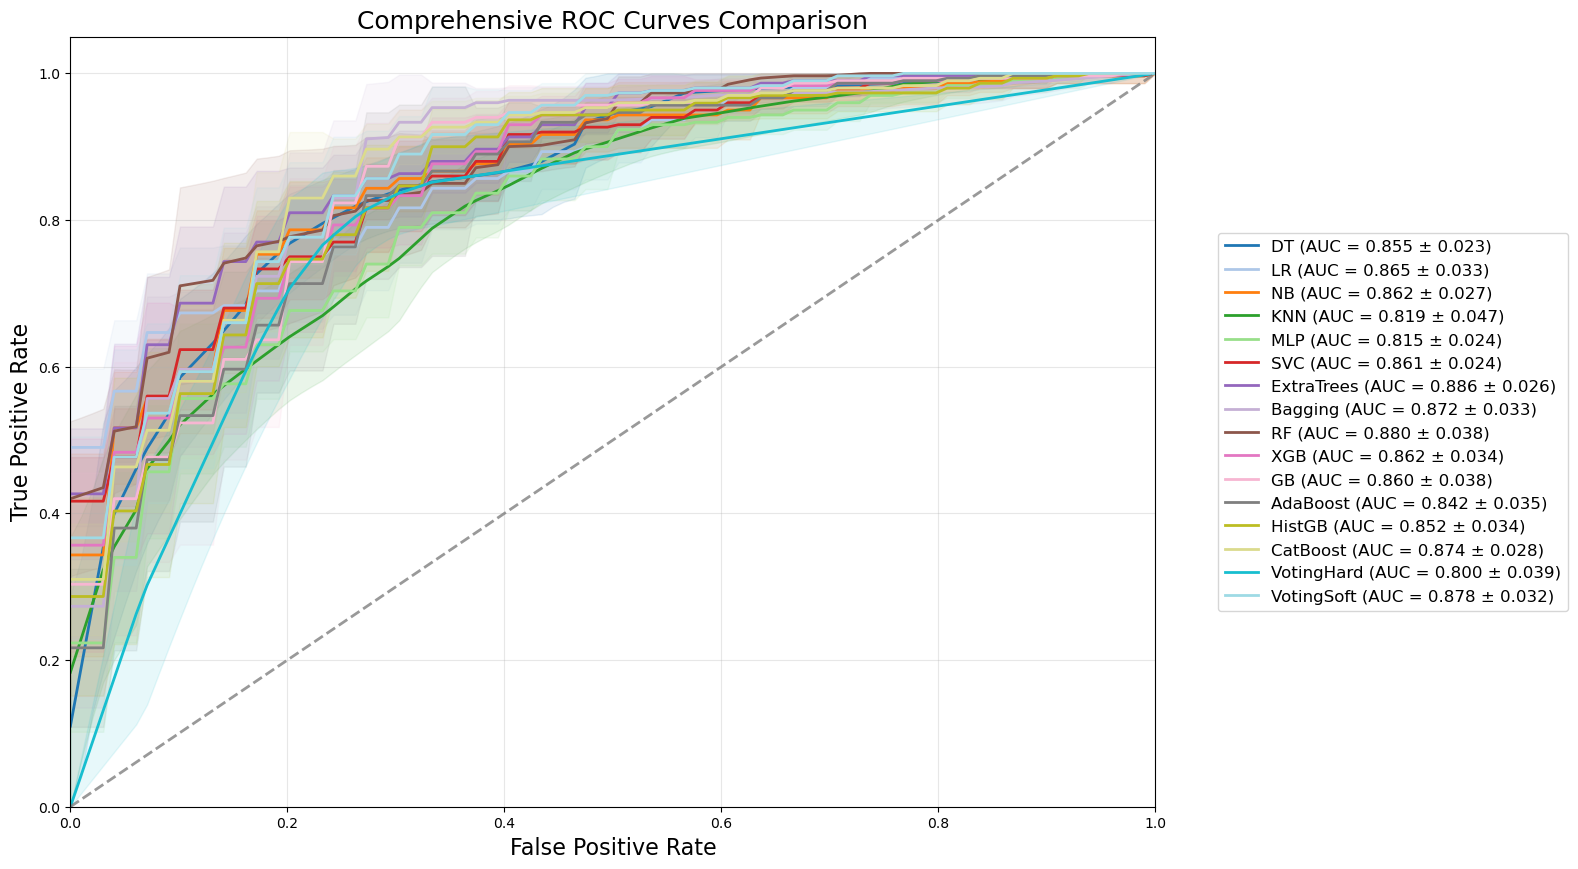


📊 AUC PERFORMANCE RANKING:
--------------------------------------------------
 1. ExtraTrees     : 0.8859 ± 0.0261
 2. RF             : 0.8798 ± 0.0383
 3. VotingSoft     : 0.8777 ± 0.0316
 4. CatBoost       : 0.8740 ± 0.0275
 5. Bagging        : 0.8723 ± 0.0335
 6. LR             : 0.8646 ± 0.0330
 7. NB             : 0.8618 ± 0.0267
 8. XGB            : 0.8616 ± 0.0337
 9. SVC            : 0.8611 ± 0.0238
10. GB             : 0.8604 ± 0.0380
11. DT             : 0.8549 ± 0.0234
12. HistGB         : 0.8516 ± 0.0345
13. AdaBoost       : 0.8421 ± 0.0348
14. KNN            : 0.8189 ± 0.0469
15. MLP            : 0.8150 ± 0.0235
16. VotingHard     : 0.8000 ± 0.0394


In [20]:
# Enhanced ROC curve plotting
if 'roc_curves' in locals() and len(roc_curves) > 0:
    auc_summary = plot_combined_roc_curve(
        roc_curves, 
        list(roc_curves.keys()), 
        "Comprehensive ROC Curves Comparison"
    )
    
    print(f"\n📊 AUC PERFORMANCE RANKING:")
    print("-" * 50)
    for i, (clf_name, mean_auc, std_auc) in enumerate(auc_summary, 1):
        print(f"{i:2d}. {clf_name:<15}: {mean_auc:.4f} ± {std_auc:.4f}")
else:
    print("No ROC data available for plotting.")

STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 52.4550
p-value: 0.000005
✓ Result: Significant differences found between classifiers
Critical Difference: 7.2946

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. VotingSoft     : 4.550
 2. ExtraTrees     : 5.000
 3. CatBoost       : 5.400
 4. VotingHard     : 5.700
 5. Bagging        : 5.750
 6. NB             : 7.450
 7. GB             : 8.100
 8. AdaBoost       : 8.700
 9. DT             : 9.050
10. RF             : 9.250
11. HistGB         : 9.400
12. XGB            : 9.450
13. SVC            : 10.200
14. LR             : 11.550
15. MLP            : 12.950
16. KNN            : 13.500


<Figure size 1600x800 with 0 Axes>

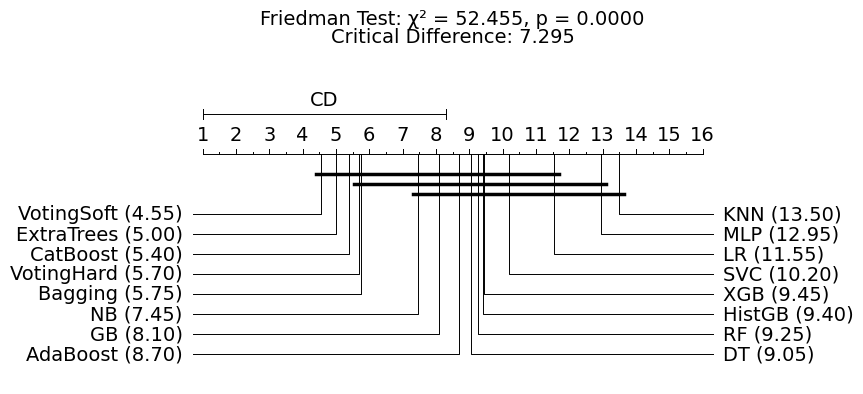

In [21]:
# Enhanced statistical analysis with better visualization
if 'accuracy_scores' in locals() and len(accuracy_scores) > 1:
    print("="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)
    
    df = pd.DataFrame(accuracy_scores)
    scores = [df[col].values for col in df.columns]
    
    try:
        stat, p = friedmanchisquare(*scores)
        print(f'Friedman Test Statistic: {stat:.4f}')
        print(f'p-value: {p:.6f}')
        
        if p < 0.05:
            print("✓ Result: Significant differences found between classifiers")
        else:
            print("⚠ Result: No significant differences found between classifiers")
        
        ranks = df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks.mean().values
        n_datasets = df.shape[0]
        
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        print(f'Critical Difference: {cd:.4f}')
        
        # Enhanced ranking display
        ranking_data = list(zip(df.columns, average_ranks))
        ranking_data.sort(key=lambda x: x[1])
        
        print(f"\n📈 CLASSIFIER RANKINGS (lower rank is better):")
        print("-" * 40)
        for i, (clf, rank) in enumerate(ranking_data, 1):
            print(f"{i:2d}. {clf:<15}: {rank:.3f}")
        
        # Critical Difference diagram with enhanced styling
        classifiers_with_ranks = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
        plt.figure(figsize=(16, 8))
        graph_ranks(average_ranks, classifiers_with_ranks, cd=cd, width=8, textspace=1.5)
        
        # Add statistical info
        plt.text(0.5, 1.22, f'Friedman Test: χ² = {stat:.3f}, p = {p:.4f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.5, 1.16, f'Critical Difference: {cd:.3f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('critical_difference_diagram.svg', format='svg', bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Statistical analysis failed: {e}")
else:
    print("Insufficient data for statistical analysis.")

### TRAINING : Static Ensemble classifiers + HYPERPARAMETER OPTIMIZATION

In [23]:
# Fix syntax error in hyperparameter optimization
if CONFIG['ENABLE_HYPEROPT']:
    # Update static hyperparameter optimization to use the new target column
    metric_sums = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices = defaultdict(list)
    roc_curves = defaultdict(list)
    roc_aucs = defaultdict(list)
    accuracy_scores = defaultdict(list)
    precision_scores = defaultdict(list)
    recall_scores = defaultdict(list)
    f1_scores = defaultdict(list)

    import numpy as np
    if not hasattr(np, 'int'):
        np.int = int

    classifiers = {
        'RandomForest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'AdaBoost': AdaBoostClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
    }

    num_features = {
         'RandomForest': 150,
         'XGBoost': 150,
         'GradientBoosting': 150,
         'AdaBoost': 150,
         'CatBoost': 150,
    }

    search_spaces = {
        'RandomForest': {
            'n_estimators': [100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 7, 15],
            'bootstrap': [True, False]
        },
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'gamma': [0, 0.2, 0.4],
        },
        'GradientBoosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [5, 10],
            'subsample': [0.7, 0.9, 1.0],
        },
        'AdaBoost': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.1, 0.5, 1.0],
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'CatBoost': {
            'iterations': [100, 200, 300],
            'depth': [5, 7, 9],
            'learning_rate': [0.01, 0.1, 0.2],
        }
    }

    def hyperparameter_optimization(clf, search_space, X, y):
        combined_results = []
        for random_state in range(3):
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            opt = BayesSearchCV(clf, search_space, n_iter=30, cv=cv, random_state=random_state, n_jobs=-1, verbose=0)
            opt.fit(X, y)
            combined_results.append(opt.best_params_)
        best_params = pd.DataFrame(combined_results).mode().iloc[0].to_dict()
        return best_params

    # FIXED: Changed from range(1) to range(CONFIG['RANDOM_STATES']) for fair comparison
    for random_state in range(CONFIG['RANDOM_STATES']):
        print(f"Processing for Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )
        
        # Identify outliers in the training dataset
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        # Select all rows that are not outliers
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()

        # Handle class imbalance with SMOTE (adjust for multi-class)
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        print(f"Number of training labels after SMOTE: {Counter(y_res)}")
        print(f"Number of test labels: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)

        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Improved Feature Selection - use RandomForest for feature importance
        rf_selector = RandomForestClassifier(n_estimators=100, random_state=random_state, max_depth=10)
        rf_selector.fit(X_res, y_res)
        
        # Get feature importance and select top features
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        # Select top 30 features instead of 50 to avoid overfitting
        top_features = [original_columns[i] for i in indices[:30]]
        
        if CONFIG['VERBOSE']:
            print(f"Top 10 features: {top_features[:10]}")

        # Only take top features
        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # Train and evaluate classifiers
        for clf_name, clf in classifiers.items():
            # Ensure the random state for classifiers is consistent
            if hasattr(clf, 'random_state'):
                clf.set_params(random_state=random_state)
            accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(clf, X_res_fi, y_res, X_test_fi, y_test, clf_name=clf_name)
            metric_sums[clf_name]['accuracy'] += accuracy
            metric_sums[clf_name]['precision'] += precision
            metric_sums[clf_name]['recall'] += recall
            metric_sums[clf_name]['f1'] += f1
            conf_matrices[clf_name].append(conf_matrix)
            roc_curves[clf_name].append((fpr, tpr))
            roc_aucs[clf_name].append(roc_auc)
            accuracy_scores[clf_name].append(accuracy)
            precision_scores[clf_name].append(precision)
            recall_scores[clf_name].append(recall)
            f1_scores[clf_name].append(f1)

    print(f"\n✓ Hyperparameter optimization completed with {CONFIG['RANDOM_STATES']} random states!")
else:
    print("Hyperparameter optimization disabled in CONFIG")

Processing for Random State: 1/10
Number of training labels after SMOTE: Counter({0: 64, 1: 64})
Number of test labels: Counter({1: 30, 0: 30})
Top 10 features: ['SevHypoEpPastYear_unaware', 'LowBGSympCat_unaware', 'Height_mod_BMedChart', 'WorryNotRecLowBG_fear', 'SymbDigWTotCorr_BTOTSCORE', 'WorryReacAlone_fear', 'BGVisit2_BTOTSCORE', 'AvoidAloneLowBG_fear', 'medications2_text_length', 'GrPegNonTotTime_BTOTSCORE']
RandomForest - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818, AUC: 0.8856
XGBoost - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1-Score: 0.7321, AUC: 0.8356
AdaBoost - Accuracy: 0.7333, Precision: 0.7376, Recall: 0.7333, F1-Score: 0.7321, AUC: 0.7589
GradientBoosting - Accuracy: 0.7833, Precision: 0.7996, Recall: 0.7833, F1-Score: 0.7803, AUC: 0.8822
CatBoost - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8833
Processing for Random State: 2/10
Number of training labels after SMOTE: Counter({1: 64, 0: 64})
Num

### TRAINING : Dynamic Ensemble classifiers

In [25]:
# Enhanced DES training with better error handling + hyperparameter optimization

from sklearn.model_selection import cross_val_score

def optimize_model(name, X, y, random_state):
    def objective(trial):
        if name == 'KNeighbors':
            n_neighbors = trial.suggest_int('n_neighbors', 3, 30)
            metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan'])
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
        elif name == 'LogisticRegression':
            C = trial.suggest_loguniform('C', 1e-4, 10)
            clf = LogisticRegression(C=C, max_iter=1000, solver='lbfgs', random_state=random_state)
        elif name == 'DecisionTree':
            max_depth = trial.suggest_int('max_depth', 3, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
            clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                         min_samples_leaf=min_samples_leaf, random_state=random_state)
        elif name == 'NaiveBayes':
            var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-12, 1e-3)
            clf = GaussianNB(var_smoothing=var_smoothing)
        elif name == 'MLP':
            alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
            hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (200,), (50, 50), (100, 50)])
            learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-1)
            clf = MLPClassifier(alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, 
                               learning_rate_init=learning_rate_init, max_iter=1000, random_state=random_state)
        elif name == 'SVC':
            C = trial.suggest_loguniform('C', 0.1, 10)
            gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            kernel = trial.suggest_categorical('kernel', ['rbf', 'linear'])
            clf = SVC(C=C, gamma=gamma, kernel=kernel, probability=True, random_state=random_state)
        elif name == 'RF':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 3, 20)
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                        criterion=criterion, random_state=random_state)
        elif name == 'XGB':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
            clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                               learning_rate=learning_rate, use_label_encoder=False, 
                               eval_metric='mlogloss', random_state=random_state)
        elif name == 'GB':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
            clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                           learning_rate=learning_rate, random_state=random_state)
        elif name == 'AB':
            n_estimators = trial.suggest_int('n_estimators', 50, 500)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 2.0)
            clf = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state)
        elif name == 'CB':
            depth = trial.suggest_int('depth', 3, 10)
            iterations = trial.suggest_int('iterations', 50, 300)
            learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
            clf = CatBoostClassifier(depth=depth, iterations=iterations, learning_rate=learning_rate, 
                                   verbose=0, random_state=random_state)
        else:
            return 0.0

        score = cross_val_score(clf, X, y, cv=3, scoring='accuracy').mean()
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, show_progress_bar=False)  # Increased trials
    best_params = study.best_params

    # Create final classifier with best hyperparams
    if name == 'KNeighbors':
        return KNeighborsClassifier(**best_params)
    elif name == 'LogisticRegression':
        return LogisticRegression(**best_params, max_iter=1000, solver='lbfgs', random_state=random_state)
    elif name == 'DecisionTree':
        return DecisionTreeClassifier(**best_params, random_state=random_state)
    elif name == 'NaiveBayes':
        return GaussianNB(**best_params)
    elif name == 'MLP':
        return MLPClassifier(**best_params, max_iter=1000, random_state=random_state)
    elif name == 'SVC':
        return SVC(**best_params, probability=True, random_state=random_state)
    elif name == 'RF':
        return RandomForestClassifier(**best_params, random_state=random_state)
    elif name == 'XGB':
        return XGBClassifier(**best_params, use_label_encoder=False, eval_metric='mlogloss', random_state=random_state)
    elif name == 'GB':
        return GradientBoostingClassifier(**best_params, random_state=random_state)
    elif name == 'AB':
        return AdaBoostClassifier(**best_params, random_state=random_state)
    elif name == 'CB':
        return CatBoostClassifier(**best_params, verbose=0, random_state=random_state)
    else:
        return None

if CONFIG['ENABLE_DES']:
    print("="*60)
    print("TRAINING DYNAMIC ENSEMBLE SELECTION MODELS")
    print("="*60)
    
    import numpy as np
    if not hasattr(np, 'float'):
        np.float = float

    # Initialize DES metrics storage
    metric_sums_des = defaultdict(lambda: {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0})
    conf_matrices_des = defaultdict(list)
    des_roc_curves = defaultdict(list)
    des_roc_aucs = defaultdict(list)
    des_accuracy_scores = defaultdict(list)
    des_precision_scores = defaultdict(list)
    des_recall_scores = defaultdict(list)
    des_f1_scores = defaultdict(list)
    feature_importance_runs = []

    # Enhanced base classifiers pool
    base_classifiers = {
        'DecisionTree': DecisionTreeClassifier(
            random_state=0, criterion='gini', max_depth=6,
            min_samples_leaf=10, min_samples_split=9
        ),
        'LogisticRegression': LogisticRegression(
            random_state=0, C=0.09659168435718246,
            max_iter=1000, solver='lbfgs'
        ),
        'NaiveBayes': GaussianNB(var_smoothing=0.0058873326349240295),
        'KNeighbors': KNeighborsClassifier(
            metric='manhattan', n_neighbors=15, weights='uniform'
        ),
        'MLP': MLPClassifier(
            random_state=0, max_iter=1000, alpha=0.0003079393718075164,
            hidden_layer_sizes=(195,), learning_rate_init=0.0001675266159417717
        ),
        'SVC': SVC(probability=True, kernel='rbf', C=1.5, gamma='auto'),
        'RF': RandomForestClassifier(
            n_estimators=143, criterion='entropy', max_depth=15, random_state=0
        ),
        #'XGB': XGBClassifier(
        #    n_estimators=200, max_depth=3, learning_rate=0.1, 
        #    use_label_encoder=False, eval_metric='mlogloss', random_state=0
        #),
        'GB': GradientBoostingClassifier(
            n_estimators=300, max_depth=3, learning_rate=0.05
        ),
        'AB': AdaBoostClassifier(n_estimators=400, learning_rate=0.1),
        'CB': CatBoostClassifier(
            depth=3, iterations=168, learning_rate=0.1, verbose=0
        )
    }

    # Training loop
    for random_state in range(CONFIG['RANDOM_STATES']):
        if CONFIG['VERBOSE']:
            print(f"\nDES Processing Random State: {random_state + 1}/{CONFIG['RANDOM_STATES']}")

        X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
        y = splitted_dataset[TARGET_COLUMN]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=random_state
        )

        # Outlier removal and preprocessing
        lof = LocalOutlierFactor()
        yhat = lof.fit_predict(X_train)
        mask = yhat != -1
        X_train, y_train = X_train[mask], y_train[mask]

        original_columns = X.columns.tolist()
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        if CONFIG['VERBOSE']:
            print(f"Training samples after SMOTE: {Counter(y_res)}")
            print(f"Test samples: {Counter(y_test)}")

        # Normalization
        scaler = MinMaxScaler()
        X_res = scaler.fit_transform(X_res)
        X_test = scaler.transform(X_test)
        X_res = pd.DataFrame(X_res, columns=original_columns)
        X_test = pd.DataFrame(X_test, columns=original_columns)

        # Feature selection
        rf_selector = RandomForestClassifier(
            n_estimators=100, random_state=random_state, max_depth=10
        )
        rf_selector.fit(X_res, y_res)
        feature_importance = rf_selector.feature_importances_
        indices = np.argsort(feature_importance)[::-1]
        
        # Select top features for DES
        top_features = [original_columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
        X_res_fi = X_res[top_features]
        X_test_fi = X_test[top_features]

        # CHANGE 2: Use consistent training data size for fair comparison
        # Instead of splitting X_res_fi again, use the full training set for model pool
        # and create a smaller validation set from the original training data
        X_pool_train, X_dsel, y_pool_train, y_dsel = train_test_split(
            X_res_fi, y_res, test_size=0.3, stratify=y_res, random_state=random_state
        )

        # Create model pool for DES - train on larger portion to match static training
        model_pool = []
        for clf_name in base_classifiers:
            try:
                clf = optimize_model(clf_name, X_pool_train, y_pool_train, random_state)
                if clf is None:
                    continue
                clf.fit(X_pool_train, y_pool_train)
                model_pool.append(clf)
                if CONFIG['VERBOSE'] and random_state == 0:
                    print(f"Added optimized {clf_name} to model pool")
            except Exception as e:
                if CONFIG['VERBOSE']:
                    print(f"Warning: Could not optimize and add {clf_name}: {e}")
                continue


        print(f"Model pool size: {len(model_pool)}")
        
        if len(model_pool) < 2:
            print("Warning: Not enough models in pool for DES. Skipping DES training.")
            continue

        # Enhanced DES models configuration with proper model pool
        des_models = {
            'KNORAE': KNORAE(pool_classifiers=model_pool),
            'KNORAU': KNORAU(pool_classifiers=model_pool),
            'DESMI': DESMI(pool_classifiers=model_pool),
            'METADES': METADES(pool_classifiers=model_pool),
            'DESKNN': DESKNN(pool_classifiers=model_pool),
            'DESP': DESP(pool_classifiers=model_pool),
            'KNOP': KNOP(pool_classifiers=model_pool, k=9)
        }

        # Add FIRE-DES variants if model pool is large enough
        if len(model_pool) >= 5:
            des_models.update({
                'FIRE-KNORA-U': KNORAU(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-KNORA-E': KNORAE(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-METADES': METADES(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-DESKNN': DESKNN(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-DESP': DESP(pool_classifiers=model_pool, DFP=True, k=9),
                'FIRE-KNOP': KNOP(pool_classifiers=model_pool, DFP=True, k=40)
            })

        # Train each DES model
        for des_name, des_model in des_models.items():
            try:
                # Fit DES model on DSEL data (smaller validation portion)
                des_model.fit(X_dsel, y_dsel)
                
                # Evaluate on test set
                accuracy, precision, recall, f1, conf_matrix, fpr, tpr, roc_auc = train_evaluate_model(
                    des_model, X_dsel, y_dsel, X_test_fi, y_test, clf_name=des_name
                )
                
                # Store metrics
                metric_sums_des[des_name]['accuracy'] += accuracy
                metric_sums_des[des_name]['precision'] += precision
                metric_sums_des[des_name]['recall'] += recall
                metric_sums_des[des_name]['f1'] += f1
                conf_matrices_des[des_name].append(conf_matrix)
                des_roc_curves[des_name].append((fpr, tpr))
                des_roc_aucs[des_name].append(roc_auc)
                des_accuracy_scores[des_name].append(accuracy)
                des_precision_scores[des_name].append(precision)
                des_recall_scores[des_name].append(recall)
                des_f1_scores[des_name].append(f1)

                if CONFIG['VERBOSE']:
                    print(f'{des_name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
                    
            except Exception as e:
                print(f"Error with {des_name}: {e}")
                # Add placeholder values to maintain consistency
                metric_sums_des[des_name]['accuracy'] += 0.0
                metric_sums_des[des_name]['precision'] += 0.0
                metric_sums_des[des_name]['recall'] += 0.0
                metric_sums_des[des_name]['f1'] += 0.0
                des_accuracy_scores[des_name].append(0.0)
                des_precision_scores[des_name].append(0.0)
                des_recall_scores[des_name].append(0.0)
                des_f1_scores[des_name].append(0.0)
                continue

    print(f"\n✓ DES training completed!")
else:
    print("DES training disabled in CONFIG")

TRAINING DYNAMIC ENSEMBLE SELECTION MODELS

DES Processing Random State: 1/10
Training samples after SMOTE: Counter({0: 64, 1: 64})
Test samples: Counter({1: 30, 0: 30})


[I 2025-06-09 11:52:41,648] A new study created in memory with name: no-name-d5a76e75-dbf4-441d-9061-33f1e0cb3c19
[I 2025-06-09 11:52:41,665] Trial 0 finished with value: 0.696168582375479 and parameters: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.696168582375479.
[I 2025-06-09 11:52:41,682] Trial 1 finished with value: 0.8191570881226053 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8191570881226053.
[I 2025-06-09 11:52:41,698] Trial 2 finished with value: 0.8425287356321839 and parameters: {'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 13}. Best is trial 2 with value: 0.8425287356321839.
[I 2025-06-09 11:52:41,714] Trial 3 finished with value: 0.7639846743295019 and parameters: {'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8425287356321839.
[I 2025-06-09 11:52:41,731] Trial 4 finished with value: 0.76

Added optimized DecisionTree to model pool


[I 2025-06-09 11:52:42,364] Trial 7 finished with value: 0.5628352490421455 and parameters: {'C': 0.0017606376096691368}. Best is trial 1 with value: 0.7191570881226053.
[I 2025-06-09 11:52:42,402] Trial 8 finished with value: 0.685823754789272 and parameters: {'C': 3.7314159150947264}. Best is trial 1 with value: 0.7191570881226053.
[I 2025-06-09 11:52:42,423] Trial 9 finished with value: 0.6183908045977011 and parameters: {'C': 0.0033450865344832933}. Best is trial 1 with value: 0.7191570881226053.
[I 2025-06-09 11:52:42,450] Trial 10 finished with value: 0.696168582375479 and parameters: {'C': 0.04100140305065473}. Best is trial 1 with value: 0.7191570881226053.
[I 2025-06-09 11:52:42,498] Trial 11 finished with value: 0.7084291187739463 and parameters: {'C': 9.60003687078374}. Best is trial 1 with value: 0.7191570881226053.
[I 2025-06-09 11:52:42,531] Trial 12 finished with value: 0.7191570881226053 and parameters: {'C': 0.3729163314221182}. Best is trial 1 with value: 0.7191570881

Added optimized LogisticRegression to model pool


[I 2025-06-09 11:52:42,950] Trial 11 finished with value: 0.7298850574712644 and parameters: {'var_smoothing': 2.6987820603272822e-08}. Best is trial 0 with value: 0.7298850574712644.
[I 2025-06-09 11:52:42,971] Trial 12 finished with value: 0.7298850574712644 and parameters: {'var_smoothing': 1.3511079383050012e-07}. Best is trial 0 with value: 0.7298850574712644.
[I 2025-06-09 11:52:42,991] Trial 13 finished with value: 0.7298850574712644 and parameters: {'var_smoothing': 2.305825270091402e-08}. Best is trial 0 with value: 0.7298850574712644.
[I 2025-06-09 11:52:43,012] Trial 14 finished with value: 0.7298850574712644 and parameters: {'var_smoothing': 4.118526502823661e-07}. Best is trial 0 with value: 0.7298850574712644.
[I 2025-06-09 11:52:43,032] Trial 15 finished with value: 0.7298850574712644 and parameters: {'var_smoothing': 3.612279811452567e-09}. Best is trial 0 with value: 0.7298850574712644.
[I 2025-06-09 11:52:43,054] Trial 16 finished with value: 0.707662835249042 and par

Added optimized NaiveBayes to model pool


[I 2025-06-09 11:52:43,461] Trial 1 finished with value: 0.6076628352490422 and parameters: {'n_neighbors': 8, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.696551724137931.
[I 2025-06-09 11:52:43,593] Trial 2 finished with value: 0.685823754789272 and parameters: {'n_neighbors': 24, 'metric': 'manhattan', 'weights': 'distance'}. Best is trial 0 with value: 0.696551724137931.
[I 2025-06-09 11:52:43,890] Trial 3 finished with value: 0.6521072796934866 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'weights': 'distance'}. Best is trial 0 with value: 0.696551724137931.
[I 2025-06-09 11:52:44,095] Trial 4 finished with value: 0.696551724137931 and parameters: {'n_neighbors': 21, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with value: 0.696551724137931.
[I 2025-06-09 11:52:44,300] Trial 5 finished with value: 0.696168582375479 and parameters: {'n_neighbors': 25, 'metric': 'euclidean', 'weights': 'uniform'}. Best is trial 0 with val

Added optimized KNeighbors to model pool


[I 2025-06-09 11:52:48,011] Trial 0 finished with value: 0.6076628352490422 and parameters: {'alpha': 0.002347138227198322, 'hidden_layer_sizes': (50,), 'learning_rate_init': 6.105596497436042e-05}. Best is trial 0 with value: 0.6076628352490422.
[I 2025-06-09 11:52:49,203] Trial 1 finished with value: 0.6183908045977011 and parameters: {'alpha': 2.6057964483807234e-05, 'hidden_layer_sizes': (50,), 'learning_rate_init': 1.3974840043739934e-05}. Best is trial 1 with value: 0.6183908045977011.
[I 2025-06-09 11:52:49,752] Trial 2 finished with value: 0.5854406130268199 and parameters: {'alpha': 0.00026772236952883784, 'hidden_layer_sizes': (200,), 'learning_rate_init': 0.00367190190069183}. Best is trial 1 with value: 0.6183908045977011.
[I 2025-06-09 11:52:49,975] Trial 3 finished with value: 0.6076628352490422 and parameters: {'alpha': 0.012607889493953067, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.00970287648263019}. Best is trial 1 with value: 0.6183908045977011.
[I 202

Added optimized MLP to model pool


[I 2025-06-09 11:53:04,669] Trial 6 finished with value: 0.6862068965517242 and parameters: {'C': 1.9116262746077348, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 4 with value: 0.7302681992337164.
[I 2025-06-09 11:53:04,692] Trial 7 finished with value: 0.6302681992337164 and parameters: {'C': 6.379829067547508, 'gamma': 'auto', 'kernel': 'linear'}. Best is trial 4 with value: 0.7302681992337164.
[I 2025-06-09 11:53:04,714] Trial 8 finished with value: 0.6298850574712643 and parameters: {'C': 0.6607805287153594, 'gamma': 'auto', 'kernel': 'rbf'}. Best is trial 4 with value: 0.7302681992337164.
[I 2025-06-09 11:53:04,735] Trial 9 finished with value: 0.7302681992337164 and parameters: {'C': 0.2199054026773852, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 4 with value: 0.7302681992337164.
[I 2025-06-09 11:53:04,762] Trial 10 finished with value: 0.7080459770114942 and parameters: {'C': 0.6143900981960757, 'gamma': 'scale', 'kernel': 'linear'}. Best is trial 4 with value: 0.7

Added optimized SVC to model pool


[I 2025-06-09 11:53:05,631] Trial 0 finished with value: 0.7417624521072798 and parameters: {'n_estimators': 128, 'max_depth': 6, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7417624521072798.
[I 2025-06-09 11:53:05,908] Trial 1 finished with value: 0.786206896551724 and parameters: {'n_estimators': 76, 'max_depth': 3, 'criterion': 'entropy'}. Best is trial 1 with value: 0.786206896551724.
[I 2025-06-09 11:53:06,416] Trial 2 finished with value: 0.7754789272030651 and parameters: {'n_estimators': 142, 'max_depth': 17, 'criterion': 'entropy'}. Best is trial 1 with value: 0.786206896551724.
[I 2025-06-09 11:53:07,264] Trial 3 finished with value: 0.775095785440613 and parameters: {'n_estimators': 243, 'max_depth': 4, 'criterion': 'entropy'}. Best is trial 1 with value: 0.786206896551724.
[I 2025-06-09 11:53:08,020] Trial 4 finished with value: 0.775095785440613 and parameters: {'n_estimators': 218, 'max_depth': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.786206896551

Added optimized RF to model pool


[I 2025-06-09 11:53:18,155] Trial 1 finished with value: 0.7417624521072796 and parameters: {'n_estimators': 157, 'max_depth': 3, 'learning_rate': 0.010597340825386733}. Best is trial 1 with value: 0.7417624521072796.
[I 2025-06-09 11:53:18,409] Trial 2 finished with value: 0.7528735632183908 and parameters: {'n_estimators': 84, 'max_depth': 10, 'learning_rate': 0.20280358882209423}. Best is trial 2 with value: 0.7528735632183908.
[I 2025-06-09 11:53:18,879] Trial 3 finished with value: 0.7865900383141763 and parameters: {'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.05788850444034126}. Best is trial 3 with value: 0.7865900383141763.
[I 2025-06-09 11:53:19,190] Trial 4 finished with value: 0.764367816091954 and parameters: {'n_estimators': 104, 'max_depth': 8, 'learning_rate': 0.05132647151356344}. Best is trial 3 with value: 0.7865900383141763.
[I 2025-06-09 11:53:19,781] Trial 5 finished with value: 0.775095785440613 and parameters: {'n_estimators': 218, 'max_depth': 3, 'le

Added optimized GB to model pool


[I 2025-06-09 11:53:27,068] Trial 0 finished with value: 0.7869731800766284 and parameters: {'n_estimators': 51, 'learning_rate': 0.03749577519699614}. Best is trial 0 with value: 0.7869731800766284.
[I 2025-06-09 11:53:27,399] Trial 1 finished with value: 0.7080459770114942 and parameters: {'n_estimators': 73, 'learning_rate': 0.21667652440521448}. Best is trial 0 with value: 0.7869731800766284.
[I 2025-06-09 11:53:28,119] Trial 2 finished with value: 0.7521072796934867 and parameters: {'n_estimators': 158, 'learning_rate': 1.0227201502888614}. Best is trial 0 with value: 0.7869731800766284.
[I 2025-06-09 11:53:29,189] Trial 3 finished with value: 0.7310344827586207 and parameters: {'n_estimators': 228, 'learning_rate': 0.0297674073817264}. Best is trial 0 with value: 0.7869731800766284.
[I 2025-06-09 11:53:30,035] Trial 4 finished with value: 0.7758620689655172 and parameters: {'n_estimators': 179, 'learning_rate': 0.01669640793663535}. Best is trial 0 with value: 0.7869731800766284.

Added optimized AB to model pool


[I 2025-06-09 11:53:46,537] Trial 0 finished with value: 0.8203065134099616 and parameters: {'depth': 4, 'iterations': 115, 'learning_rate': 0.05432367386750442}. Best is trial 0 with value: 0.8203065134099616.
[I 2025-06-09 11:53:47,663] Trial 1 finished with value: 0.8314176245210728 and parameters: {'depth': 4, 'iterations': 134, 'learning_rate': 0.03712957363653838}. Best is trial 1 with value: 0.8314176245210728.
[I 2025-06-09 11:53:51,156] Trial 2 finished with value: 0.8314176245210728 and parameters: {'depth': 10, 'iterations': 229, 'learning_rate': 0.02330433281757538}. Best is trial 1 with value: 0.8314176245210728.
[I 2025-06-09 11:53:52,769] Trial 3 finished with value: 0.8088122605363984 and parameters: {'depth': 5, 'iterations': 271, 'learning_rate': 0.03493344995440765}. Best is trial 1 with value: 0.8314176245210728.
[I 2025-06-09 11:53:53,685] Trial 4 finished with value: 0.775095785440613 and parameters: {'depth': 5, 'iterations': 80, 'learning_rate': 0.17494880698699

Added optimized CB to model pool
Model pool size: 10
KNORAE - Accuracy: 0.7500, Precision: 0.7525, Recall: 0.7500, F1-Score: 0.7494, AUC: 0.8833
KNORAE - Accuracy: 0.7500, F1: 0.7494
KNORAU - Accuracy: 0.7667, Precision: 0.7871, Recall: 0.7667, F1-Score: 0.7624, AUC: 0.8567
KNORAU - Accuracy: 0.7667, F1: 0.7624
DESMI - Accuracy: 0.7667, Precision: 0.7871, Recall: 0.7667, F1-Score: 0.7624, AUC: 0.8667
DESMI - Accuracy: 0.7667, F1: 0.7624
METADES - Accuracy: 0.8167, Precision: 0.8349, Recall: 0.8167, F1-Score: 0.8141, AUC: 0.8833
METADES - Accuracy: 0.8167, F1: 0.8141
DESKNN - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818, AUC: 0.8978
DESKNN - Accuracy: 0.7833, F1: 0.7818
DESP - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8711
DESP - Accuracy: 0.7667, F1: 0.7643
KNOP - Accuracy: 0.7833, Precision: 0.8114, Recall: 0.7833, F1-Score: 0.7783, AUC: 0.8289
KNOP - Accuracy: 0.7833, F1: 0.7783
FIRE-KNORA-U - Accuracy: 0.7833, Precision: 0

[I 2025-06-09 11:54:32,736] A new study created in memory with name: no-name-9a5abb1c-c361-4627-ae5e-2fc6e0babd90
[I 2025-06-09 11:54:32,754] Trial 0 finished with value: 0.7854406130268199 and parameters: {'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7854406130268199.
[I 2025-06-09 11:54:32,771] Trial 1 finished with value: 0.7528735632183908 and parameters: {'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7854406130268199.
[I 2025-06-09 11:54:32,788] Trial 2 finished with value: 0.7528735632183908 and parameters: {'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7854406130268199.
[I 2025-06-09 11:54:32,805] Trial 3 finished with value: 0.7739463601532567 and parameters: {'max_depth': 16, 'min_samples_split': 13, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.7854406130268199.
[I 2025-06-09 11:54:32,822] Trial 4 finished with value: 0.7

Model pool size: 10
KNORAE - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8733
KNORAE - Accuracy: 0.8000, F1: 0.7998
KNORAU - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8700
KNORAU - Accuracy: 0.8000, F1: 0.7998
DESMI - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8800
DESMI - Accuracy: 0.8167, F1: 0.8166
METADES - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8711
METADES - Accuracy: 0.8000, F1: 0.7998
DESKNN - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8833
DESKNN - Accuracy: 0.8167, F1: 0.8166
DESP - Accuracy: 0.7667, Precision: 0.7679, Recall: 0.7667, F1-Score: 0.7664, AUC: 0.8589
DESP - Accuracy: 0.7667, F1: 0.7664
KNOP - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8711
KNOP - Accuracy: 0.8167, F1: 0.8166
FIRE-KNORA-U - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 

[I 2025-06-09 11:56:50,119] A new study created in memory with name: no-name-20192721-1789-41a7-ad97-2da9dd8b6cef
[I 2025-06-09 11:56:50,136] Trial 0 finished with value: 0.7402298850574712 and parameters: {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7402298850574712.
[I 2025-06-09 11:56:50,153] Trial 1 finished with value: 0.7160919540229885 and parameters: {'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7402298850574712.
[I 2025-06-09 11:56:50,170] Trial 2 finished with value: 0.7160919540229885 and parameters: {'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.7402298850574712.
[I 2025-06-09 11:56:50,186] Trial 3 finished with value: 0.7402298850574712 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7402298850574712.
[I 2025-06-09 11:56:50,199] Trial 4 finished with value: 0.818

Model pool size: 10
KNORAE - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828, AUC: 0.8644
KNORAE - Accuracy: 0.7833, F1: 0.7828
KNORAU - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 0.8490, AUC: 0.8578
KNORAU - Accuracy: 0.8500, F1: 0.8490
DESMI - Accuracy: 0.8333, Precision: 0.8394, Recall: 0.8333, F1-Score: 0.8326, AUC: 0.8833
DESMI - Accuracy: 0.8333, F1: 0.8326
METADES - Accuracy: 0.8333, Precision: 0.8394, Recall: 0.8333, F1-Score: 0.8326, AUC: 0.9044
METADES - Accuracy: 0.8333, F1: 0.8326
DESKNN - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 0.8490, AUC: 0.8644
DESKNN - Accuracy: 0.8500, F1: 0.8490
DESP - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 0.8490, AUC: 0.9144
DESP - Accuracy: 0.8500, F1: 0.8490
KNOP - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 0.8490, AUC: 0.8500
KNOP - Accuracy: 0.8500, F1: 0.8490
FIRE-KNORA-U - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 

[I 2025-06-09 11:58:56,314] A new study created in memory with name: no-name-98e14fe5-c804-4488-850d-4514aa87359f
[I 2025-06-09 11:58:56,328] Trial 0 finished with value: 0.8314176245210728 and parameters: {'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8314176245210728.
[I 2025-06-09 11:58:56,341] Trial 1 finished with value: 0.8314176245210728 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.8314176245210728.
[I 2025-06-09 11:58:56,354] Trial 2 finished with value: 0.6957854406130268 and parameters: {'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8314176245210728.
[I 2025-06-09 11:58:56,368] Trial 3 finished with value: 0.7647509578544062 and parameters: {'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8314176245210728.
[I 2025-06-09 11:58:56,381] Trial 4 finished with value: 0.

Model pool size: 10
KNORAE - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.9044
KNORAE - Accuracy: 0.8000, F1: 0.8000
KNORAU - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818, AUC: 0.8922
KNORAU - Accuracy: 0.7833, F1: 0.7818
DESMI - Accuracy: 0.8333, Precision: 0.8394, Recall: 0.8333, F1-Score: 0.8326, AUC: 0.9156
DESMI - Accuracy: 0.8333, F1: 0.8326
METADES - Accuracy: 0.7667, Precision: 0.7715, Recall: 0.7667, F1-Score: 0.7656, AUC: 0.9089
METADES - Accuracy: 0.7667, F1: 0.7656
DESKNN - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828, AUC: 0.8878
DESKNN - Accuracy: 0.7833, F1: 0.7828
DESP - Accuracy: 0.8167, Precision: 0.8199, Recall: 0.8167, F1-Score: 0.8162, AUC: 0.8967
DESP - Accuracy: 0.8167, F1: 0.8162
KNOP - Accuracy: 0.7833, Precision: 0.7914, Recall: 0.7833, F1-Score: 0.7818, AUC: 0.8911
KNOP - Accuracy: 0.7833, F1: 0.7818
FIRE-KNORA-U - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 

[I 2025-06-09 12:01:05,537] A new study created in memory with name: no-name-98a00bd7-4551-40b0-bbe9-c826f3eb79a7
[I 2025-06-09 12:01:05,554] Trial 0 finished with value: 0.6924731182795698 and parameters: {'max_depth': 14, 'min_samples_split': 19, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.6924731182795698.
[I 2025-06-09 12:01:05,569] Trial 1 finished with value: 0.7584229390681004 and parameters: {'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7584229390681004.
[I 2025-06-09 12:01:05,583] Trial 2 finished with value: 0.7250896057347669 and parameters: {'max_depth': 14, 'min_samples_split': 11, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.7584229390681004.
[I 2025-06-09 12:01:05,597] Trial 3 finished with value: 0.7469534050179211 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7584229390681004.
[I 2025-06-09 12:01:05,610] Trial 4 finished with value: 0

Model pool size: 10
KNORAE - Accuracy: 0.7833, Precision: 0.7836, Recall: 0.7833, F1-Score: 0.7833, AUC: 0.8567
KNORAE - Accuracy: 0.7833, F1: 0.7833
KNORAU - Accuracy: 0.8333, Precision: 0.8348, Recall: 0.8333, F1-Score: 0.8331, AUC: 0.8800
KNORAU - Accuracy: 0.8333, F1: 0.8331
DESMI - Accuracy: 0.8000, Precision: 0.8054, Recall: 0.8000, F1-Score: 0.7991, AUC: 0.8878
DESMI - Accuracy: 0.8000, F1: 0.7991
METADES - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8822
METADES - Accuracy: 0.8167, F1: 0.8166
DESKNN - Accuracy: 0.7833, Precision: 0.7836, Recall: 0.7833, F1-Score: 0.7833, AUC: 0.8833
DESKNN - Accuracy: 0.7833, F1: 0.7833
DESP - Accuracy: 0.8333, Precision: 0.8348, Recall: 0.8333, F1-Score: 0.8331, AUC: 0.8778
DESP - Accuracy: 0.8333, F1: 0.8331
KNOP - Accuracy: 0.8167, Precision: 0.8199, Recall: 0.8167, F1-Score: 0.8162, AUC: 0.8522
KNOP - Accuracy: 0.8167, F1: 0.8162
FIRE-KNORA-U - Accuracy: 0.8167, Precision: 0.8199, Recall: 0.8167, F1-Score: 

[I 2025-06-09 12:04:03,465] A new study created in memory with name: no-name-a9ca763f-4f90-4bc5-8bfc-1d235853e7e9
[I 2025-06-09 12:04:03,483] Trial 0 finished with value: 0.7279693486590038 and parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7279693486590038.
[I 2025-06-09 12:04:03,500] Trial 1 finished with value: 0.6693486590038314 and parameters: {'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7279693486590038.
[I 2025-06-09 12:04:03,516] Trial 2 finished with value: 0.7279693486590038 and parameters: {'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7279693486590038.
[I 2025-06-09 12:04:03,533] Trial 3 finished with value: 0.7279693486590038 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.7279693486590038.
[I 2025-06-09 12:04:03,550] Trial 4 finished with value: 0.658

Model pool size: 10
KNORAE - Accuracy: 0.7333, Precision: 0.7344, Recall: 0.7333, F1-Score: 0.7330, AUC: 0.8844
KNORAE - Accuracy: 0.7333, F1: 0.7330
KNORAU - Accuracy: 0.7833, Precision: 0.7862, Recall: 0.7833, F1-Score: 0.7828, AUC: 0.8622
KNORAU - Accuracy: 0.7833, F1: 0.7828
DESMI - Accuracy: 0.7667, Precision: 0.7679, Recall: 0.7667, F1-Score: 0.7664, AUC: 0.8689
DESMI - Accuracy: 0.7667, F1: 0.7664
METADES - Accuracy: 0.8500, Precision: 0.8600, Recall: 0.8500, F1-Score: 0.8490, AUC: 0.9100
METADES - Accuracy: 0.8500, F1: 0.8490
DESKNN - Accuracy: 0.7833, Precision: 0.7836, Recall: 0.7833, F1-Score: 0.7833, AUC: 0.8911
DESKNN - Accuracy: 0.7833, F1: 0.7833
DESP - Accuracy: 0.7167, Precision: 0.7169, Recall: 0.7167, F1-Score: 0.7166, AUC: 0.8778
DESP - Accuracy: 0.7167, F1: 0.7166
KNOP - Accuracy: 0.7833, Precision: 0.7836, Recall: 0.7833, F1-Score: 0.7833, AUC: 0.9022
KNOP - Accuracy: 0.7833, F1: 0.7833
FIRE-KNORA-U - Accuracy: 0.7667, Precision: 0.7667, Recall: 0.7667, F1-Score: 

[I 2025-06-09 12:06:15,538] A new study created in memory with name: no-name-680399e2-4291-4d6c-bda7-631772723042
[I 2025-06-09 12:06:15,556] Trial 0 finished with value: 0.7580645161290324 and parameters: {'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.7580645161290324.
[I 2025-06-09 12:06:15,573] Trial 1 finished with value: 0.7354838709677419 and parameters: {'max_depth': 16, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7580645161290324.
[I 2025-06-09 12:06:15,590] Trial 2 finished with value: 0.7580645161290324 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7580645161290324.
[I 2025-06-09 12:06:15,608] Trial 3 finished with value: 0.746594982078853 and parameters: {'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7580645161290324.
[I 2025-06-09 12:06:15,626] Trial 4 finished with value: 0.

Model pool size: 10
KNORAE - Accuracy: 0.7500, Precision: 0.7503, Recall: 0.7500, F1-Score: 0.7499, AUC: 0.7889
KNORAE - Accuracy: 0.7500, F1: 0.7499
KNORAU - Accuracy: 0.7333, Precision: 0.7344, Recall: 0.7333, F1-Score: 0.7330, AUC: 0.7733
KNORAU - Accuracy: 0.7333, F1: 0.7330
DESMI - Accuracy: 0.7500, Precision: 0.7503, Recall: 0.7500, F1-Score: 0.7499, AUC: 0.8489
DESMI - Accuracy: 0.7500, F1: 0.7499
METADES - Accuracy: 0.7167, Precision: 0.7229, Recall: 0.7167, F1-Score: 0.7147, AUC: 0.7822
METADES - Accuracy: 0.7167, F1: 0.7147
DESKNN - Accuracy: 0.7333, Precision: 0.7344, Recall: 0.7333, F1-Score: 0.7330, AUC: 0.8333
DESKNN - Accuracy: 0.7333, F1: 0.7330
DESP - Accuracy: 0.7333, Precision: 0.7344, Recall: 0.7333, F1-Score: 0.7330, AUC: 0.8311
DESP - Accuracy: 0.7333, F1: 0.7330
KNOP - Accuracy: 0.7667, Precision: 0.7667, Recall: 0.7667, F1-Score: 0.7667, AUC: 0.7433
KNOP - Accuracy: 0.7667, F1: 0.7667
FIRE-KNORA-U - Accuracy: 0.7167, Precision: 0.7169, Recall: 0.7167, F1-Score: 

[I 2025-06-09 12:08:19,345] A new study created in memory with name: no-name-f301feb7-6e59-4e9b-8164-34822fdec65c
[I 2025-06-09 12:08:19,363] Trial 0 finished with value: 0.6711822660098523 and parameters: {'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6711822660098523.
[I 2025-06-09 12:08:19,379] Trial 1 finished with value: 0.730295566502463 and parameters: {'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.730295566502463.
[I 2025-06-09 12:08:19,396] Trial 2 finished with value: 0.6588669950738916 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.730295566502463.
[I 2025-06-09 12:08:19,412] Trial 3 finished with value: 0.5636288998357964 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.730295566502463.
[I 2025-06-09 12:08:19,429] Trial 4 finished with value: 0.671

Model pool size: 10
KNORAE - Accuracy: 0.8167, Precision: 0.8199, Recall: 0.8167, F1-Score: 0.8162, AUC: 0.9122
KNORAE - Accuracy: 0.8167, F1: 0.8162
KNORAU - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.9078
KNORAU - Accuracy: 0.8167, F1: 0.8166
DESMI - Accuracy: 0.8167, Precision: 0.8257, Recall: 0.8167, F1-Score: 0.8154, AUC: 0.9300
DESMI - Accuracy: 0.8167, F1: 0.8154
METADES - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8978
METADES - Accuracy: 0.8167, F1: 0.8166
DESKNN - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.9011
DESKNN - Accuracy: 0.8000, F1: 0.7998
DESP - Accuracy: 0.8333, Precision: 0.8333, Recall: 0.8333, F1-Score: 0.8333, AUC: 0.9267
DESP - Accuracy: 0.8333, F1: 0.8333
KNOP - Accuracy: 0.8333, Precision: 0.8348, Recall: 0.8333, F1-Score: 0.8331, AUC: 0.9022
KNOP - Accuracy: 0.8333, F1: 0.8331
FIRE-KNORA-U - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 

[I 2025-06-09 12:10:15,712] A new study created in memory with name: no-name-cf7920da-5259-485a-8974-1db28fefb52b
[I 2025-06-09 12:10:15,729] Trial 0 finished with value: 0.8187739463601532 and parameters: {'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.8187739463601532.
[I 2025-06-09 12:10:15,746] Trial 1 finished with value: 0.7624521072796936 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8187739463601532.
[I 2025-06-09 12:10:15,763] Trial 2 finished with value: 0.7624521072796936 and parameters: {'max_depth': 16, 'min_samples_split': 14, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.8187739463601532.
[I 2025-06-09 12:10:15,781] Trial 3 finished with value: 0.806896551724138 and parameters: {'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8187739463601532.
[I 2025-06-09 12:10:15,797] Trial 4 finished with value: 0

Model pool size: 10
KNORAE - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.9078
KNORAE - Accuracy: 0.8167, F1: 0.8166
KNORAU - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8956
KNORAU - Accuracy: 0.8167, F1: 0.8166
DESMI - Accuracy: 0.8000, Precision: 0.8000, Recall: 0.8000, F1-Score: 0.8000, AUC: 0.8856
DESMI - Accuracy: 0.8000, F1: 0.8000
METADES - Accuracy: 0.8333, Precision: 0.8333, Recall: 0.8333, F1-Score: 0.8333, AUC: 0.8900
METADES - Accuracy: 0.8333, F1: 0.8333
DESKNN - Accuracy: 0.8000, Precision: 0.8013, Recall: 0.8000, F1-Score: 0.7998, AUC: 0.8933
DESKNN - Accuracy: 0.8000, F1: 0.7998
DESP - Accuracy: 0.8333, Precision: 0.8333, Recall: 0.8333, F1-Score: 0.8333, AUC: 0.8989
DESP - Accuracy: 0.8333, F1: 0.8333
KNOP - Accuracy: 0.8167, Precision: 0.8170, Recall: 0.8167, F1-Score: 0.8166, AUC: 0.8889
KNOP - Accuracy: 0.8167, F1: 0.8166
FIRE-KNORA-U - Accuracy: 0.8333, Precision: 0.8348, Recall: 0.8333, F1-Score: 

[I 2025-06-09 12:12:07,359] A new study created in memory with name: no-name-f6ebf0c9-3766-450d-907b-fea8b633390e
[I 2025-06-09 12:12:07,373] Trial 0 finished with value: 0.7053639846743295 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7053639846743295.
[I 2025-06-09 12:12:07,386] Trial 1 finished with value: 0.7628352490421455 and parameters: {'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7628352490421455.
[I 2025-06-09 12:12:07,399] Trial 2 finished with value: 0.7628352490421455 and parameters: {'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7628352490421455.
[I 2025-06-09 12:12:07,411] Trial 3 finished with value: 0.7839080459770115 and parameters: {'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.7839080459770115.
[I 2025-06-09 12:12:07,424] Trial 4 finished with value: 0.7

Model pool size: 10
KNORAE - Accuracy: 0.7667, Precision: 0.7778, Recall: 0.7667, F1-Score: 0.7643, AUC: 0.8656
KNORAE - Accuracy: 0.7667, F1: 0.7643
KNORAU - Accuracy: 0.7667, Precision: 0.7871, Recall: 0.7667, F1-Score: 0.7624, AUC: 0.8744
KNORAU - Accuracy: 0.7667, F1: 0.7624
DESMI - Accuracy: 0.8000, Precision: 0.8125, Recall: 0.8000, F1-Score: 0.7980, AUC: 0.9322
DESMI - Accuracy: 0.8000, F1: 0.7980
METADES - Accuracy: 0.8000, Precision: 0.8125, Recall: 0.8000, F1-Score: 0.7980, AUC: 0.9333
METADES - Accuracy: 0.8000, F1: 0.7980
DESKNN - Accuracy: 0.7500, Precision: 0.7747, Recall: 0.7500, F1-Score: 0.7442, AUC: 0.8911
DESKNN - Accuracy: 0.7500, F1: 0.7442
DESP - Accuracy: 0.7667, Precision: 0.7871, Recall: 0.7667, F1-Score: 0.7624, AUC: 0.9067
DESP - Accuracy: 0.7667, F1: 0.7624
KNOP - Accuracy: 0.7667, Precision: 0.7871, Recall: 0.7667, F1-Score: 0.7624, AUC: 0.8211
KNOP - Accuracy: 0.7667, F1: 0.7624
FIRE-KNORA-U - Accuracy: 0.7833, Precision: 0.7996, Recall: 0.7833, F1-Score: 

📈 ROC CURVE ANALYSIS FOR DYNAMIC ENSEMBLE SELECTION


/home/researchsrv1/clement/DES4DepressionTest/code/roc_curves_for_des_models.svg

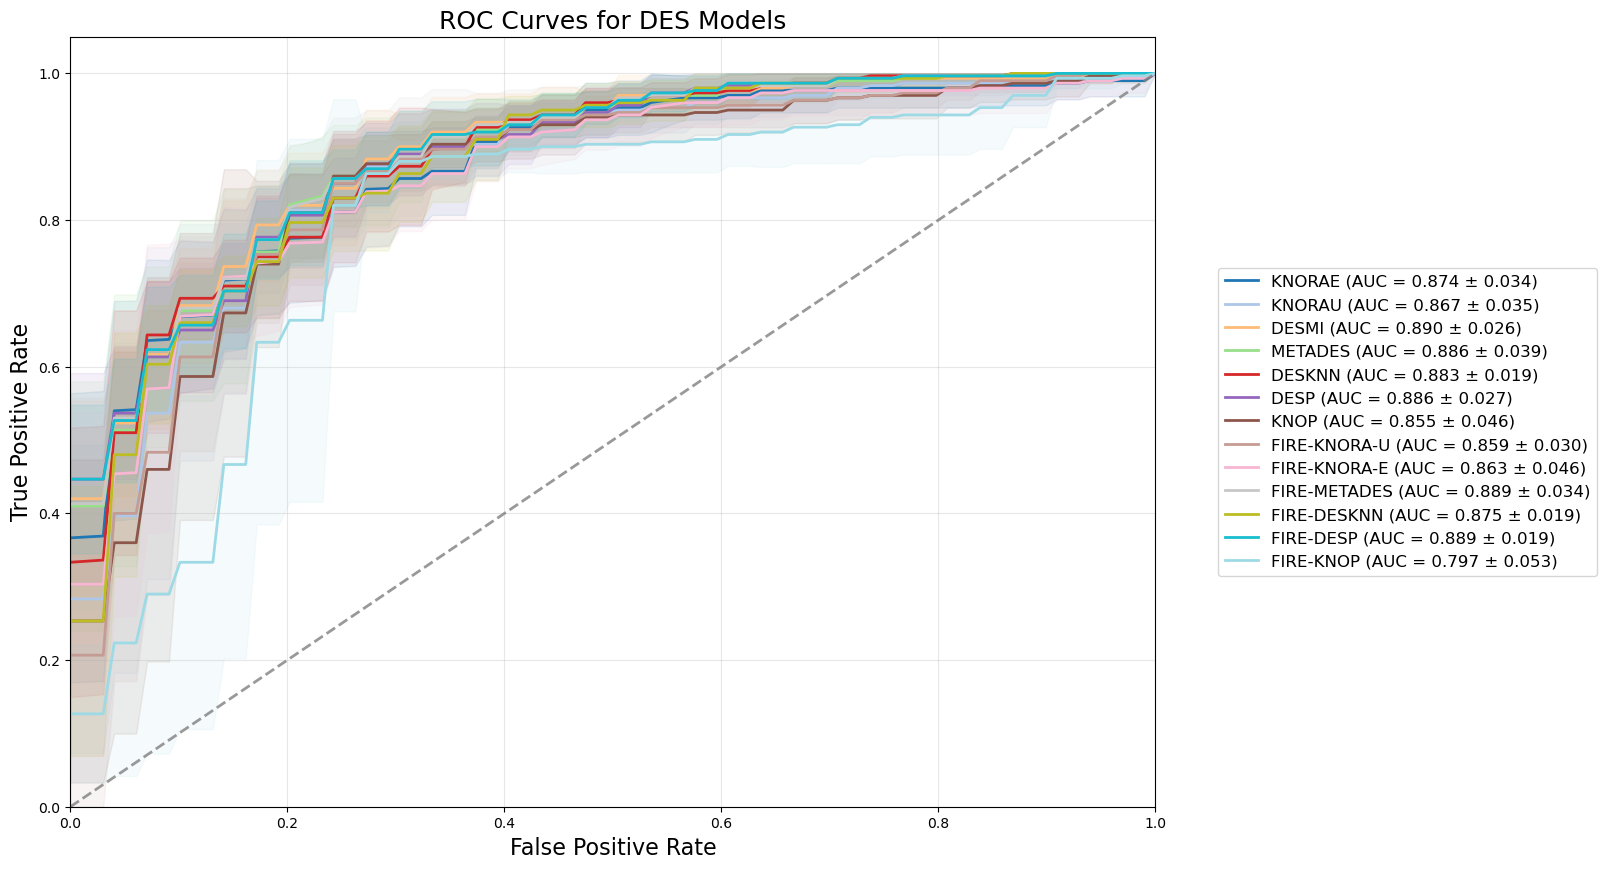


📊 AUC PERFORMANCE RANKING FOR DES MODELS:
------------------------------------------------------------
 1. DESMI               : 0.8899 ± 0.0262
 2. FIRE-DESP           : 0.8891 ± 0.0190
 3. FIRE-METADES        : 0.8888 ± 0.0335
 4. METADES             : 0.8863 ± 0.0385
 5. DESP                : 0.8860 ± 0.0270
 6. DESKNN              : 0.8827 ± 0.0190
 7. FIRE-DESKNN         : 0.8749 ± 0.0191
 8. KNORAE              : 0.8741 ± 0.0338
 9. KNORAU              : 0.8670 ± 0.0351
10. FIRE-KNORA-E        : 0.8626 ± 0.0456
11. FIRE-KNORA-U        : 0.8586 ± 0.0298
12. KNOP                : 0.8551 ± 0.0464
13. FIRE-KNOP           : 0.7974 ± 0.0532


In [26]:
# ROC curve plotting for DES models
if 'des_roc_curves' in locals() and len(des_roc_curves) > 0:
    from sklearn.metrics import auc  # Safe re-import in case auc was overwritten earlier
    
    print("="*60)
    print("📈 ROC CURVE ANALYSIS FOR DYNAMIC ENSEMBLE SELECTION")
    print("="*60)
    
    des_auc_summary = plot_combined_roc_curve(
        des_roc_curves,
        list(des_roc_curves.keys()),
        "ROC Curves for DES Models"
    )
    
    print(f"\n📊 AUC PERFORMANCE RANKING FOR DES MODELS:")
    print("-" * 60)
    for i, (clf_name, mean_auc, std_auc) in enumerate(des_auc_summary, 1):
        print(f"{i:2d}. {clf_name:<20}: {mean_auc:.4f} ± {std_auc:.4f}")
else:
    print("No ROC data available for DES models.")


STATISTICAL SIGNIFICANCE ANALYSIS
Friedman Test Statistic: 18.4000
p-value: 0.001031
✓ Result: Significant differences found between classifiers
Critical Difference: 1.9288

📈 CLASSIFIER RANKINGS (lower rank is better):
----------------------------------------
 1. CatBoost       : 1.950
 2. GradientBoosting: 2.500
 3. XGBoost        : 2.900
 4. RandomForest   : 2.950
 5. AdaBoost       : 4.700


<Figure size 1600x800 with 0 Axes>

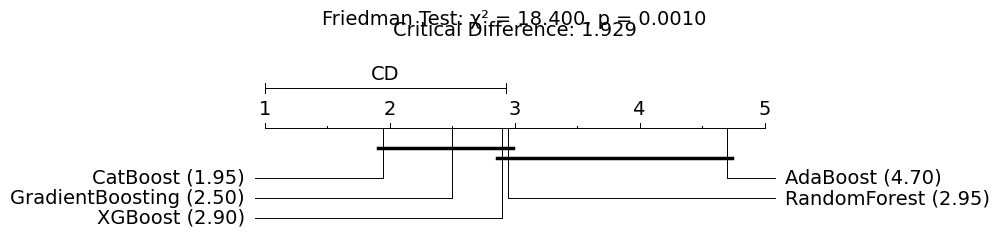

In [27]:
# Enhanced statistical analysis with better visualization
if 'accuracy_scores' in locals() and len(accuracy_scores) > 1:
    print("="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)
    
    df = pd.DataFrame(accuracy_scores)
    scores = [df[col].values for col in df.columns]
    
    try:
        stat, p = friedmanchisquare(*scores)
        print(f'Friedman Test Statistic: {stat:.4f}')
        print(f'p-value: {p:.6f}')
        
        if p < 0.05:
            print("✓ Result: Significant differences found between classifiers")
        else:
            print("⚠ Result: No significant differences found between classifiers")
        
        ranks = df.rank(axis=1, method='average', ascending=False)
        average_ranks = ranks.mean().values
        n_datasets = df.shape[0]
        
        cd = compute_CD(average_ranks, n_datasets, alpha='0.05')
        print(f'Critical Difference: {cd:.4f}')
        
        # Enhanced ranking display
        ranking_data = list(zip(df.columns, average_ranks))
        ranking_data.sort(key=lambda x: x[1])
        
        print(f"\n📈 CLASSIFIER RANKINGS (lower rank is better):")
        print("-" * 40)
        for i, (clf, rank) in enumerate(ranking_data, 1):
            print(f"{i:2d}. {clf:<15}: {rank:.3f}")
        
        # Critical Difference diagram with enhanced styling
        classifiers_with_ranks = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]
        plt.figure(figsize=(16, 8))
        graph_ranks(average_ranks, classifiers_with_ranks, cd=cd, width=8, textspace=1.5)
        
        # Add statistical info
        plt.text(0.5, 1.22, f'Friedman Test: χ² = {stat:.3f}, p = {p:.4f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        plt.text(0.5, 1.16, f'Critical Difference: {cd:.3f}', 
                horizontalalignment='center', transform=plt.gca().transAxes, fontsize=14)
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('critical_difference_diagram_DES.svg', format='svg', bbox_inches='tight')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Statistical analysis failed: {e}")
else:
    print("Insufficient data for statistical analysis.")

In [28]:
# Final comprehensive analysis and recommendations
if 'accuracy_scores' in locals() or 'des_accuracy_scores' in locals():
    print("="*80)
    print("FINAL EXPERIMENT SUMMARY AND RECOMMENDATIONS")
    print("="*80)
    
    # Combine all results
    all_results = {}
    all_precision = {}
    all_f1 = {}
    all_auc = {}
    
    if 'accuracy_scores' in locals():
        all_results.update(accuracy_scores)
    if 'des_accuracy_scores' in locals():
        all_results.update(des_accuracy_scores)
        
    if 'precision_scores' in locals():
        all_precision.update(precision_scores)
    if 'des_precision_scores' in locals():
        all_precision.update(des_precision_scores)
        
    if 'f1_scores' in locals():
        all_f1.update(f1_scores)
    if 'des_f1_scores' in locals():
        all_f1.update(des_f1_scores)
        
    if 'roc_aucs' in locals():
        all_auc.update(roc_aucs)
    if 'des_roc_aucs' in locals():
        all_auc.update(des_roc_aucs)
    
    if all_results:
        # Overall performance ranking with multiple metrics
        overall_performance = []
        for clf_name, scores in all_results.items():
            if len(scores) > 0:
                mean_accuracy = np.mean(scores)
                std_accuracy = np.std(scores)
                
                # Get precision metrics
                mean_precision = np.mean(all_precision[clf_name]) if clf_name in all_precision and len(all_precision[clf_name]) > 0 else 0.0
                std_precision = np.std(all_precision[clf_name]) if clf_name in all_precision and len(all_precision[clf_name]) > 0 else 0.0
                
                # Get F1 metrics
                mean_f1 = np.mean(all_f1[clf_name]) if clf_name in all_f1 and len(all_f1[clf_name]) > 0 else 0.0
                std_f1 = np.std(all_f1[clf_name]) if clf_name in all_f1 and len(all_f1[clf_name]) > 0 else 0.0
                
                # Get AUC metrics
                mean_auc = np.mean(all_auc[clf_name]) if clf_name in all_auc and len(all_auc[clf_name]) > 0 else 0.0
                std_auc = np.std(all_auc[clf_name]) if clf_name in all_auc and len(all_auc[clf_name]) > 0 else 0.0
                
                overall_performance.append((clf_name, mean_accuracy, std_accuracy, mean_precision, std_precision, mean_f1, std_f1, mean_auc, std_auc))
        
        # Sort by accuracy (primary), then by AUC (secondary)
        overall_performance.sort(key=lambda x: (x[1], x[7]), reverse=True)
        
        print(f"\n🏆 OVERALL TOP 15 PERFORMERS:")
        print("-" * 120)
        print(f"{'Rank':<4} {'Classifier':<18} {'Accuracy':<18} {'Precision':<18} {'F1-Score':<18} {'AUC-ROC':<18} {'Grade':<8}")
        print("-" * 120)
        
        for i, (clf_name, mean_acc, std_acc, mean_prec, std_prec, mean_f1, std_f1, mean_auc, std_auc) in enumerate(overall_performance[:15], 1):
            # Performance grading based on accuracy
            if mean_acc >= 0.90:
                grade = "A+"
            elif mean_acc >= 0.85:
                grade = "A"
            elif mean_acc >= 0.80:
                grade = "B+"
            elif mean_acc >= 0.75:
                grade = "B"
            else:
                grade = "C"
                
            print(f"{i:<4} {clf_name:<18} {mean_acc:.3f}±{std_acc:.3f}      {mean_prec:.3f}±{std_prec:.3f}      {mean_f1:.3f}±{std_f1:.3f}      {mean_auc:.3f}±{std_auc:.3f}      {grade:<8}")
        
        # Enhanced model recommendations
        best_model = overall_performance[0]
        most_stable = min(overall_performance, key=lambda x: x[2])  # Min std_accuracy
        best_auc = max(overall_performance, key=lambda x: x[7])      # Max mean_auc
        best_precision = max(overall_performance, key=lambda x: x[3]) # Max mean_precision
        
        print(f"\n📋 DETAILED RECOMMENDATIONS:")
        print("-" * 50)
        print(f"🥇 Best Overall (Accuracy): {best_model[0]} ({best_model[1]:.4f})")
        print(f"🎯 Most Stable (Low Std):   {most_stable[0]} (Std: {most_stable[2]:.4f})")
        print(f"📊 Best AUC-ROC:           {best_auc[0]} ({best_auc[7]:.4f})")
        print(f"🎪 Best Precision:         {best_precision[0]} ({best_precision[3]:.4f})")
        
        # Performance categories
        excellent = [x for x in overall_performance if x[1] >= 0.85]
        good = [x for x in overall_performance if 0.80 <= x[1] < 0.85]
        high_auc = [x for x in overall_performance if x[7] >= 0.85]
        
        print(f"\n📈 PERFORMANCE ANALYSIS:")
        print("-" * 40)
        if excellent:
            print(f"⭐ {len(excellent)} models achieved excellent accuracy (≥85%)")
            excellent_names = [x[0] for x in excellent]
            print(f"   Models: {', '.join(excellent_names)}")
        if good:
            print(f"✓ {len(good)} models achieved good accuracy (80-85%)")
            good_names = [x[0] for x in good]
            print(f"   Models: {', '.join(good_names)}")
        if high_auc:
            print(f"🎯 {len(high_auc)} models achieved high AUC-ROC (≥85%)")
            high_auc_names = [x[0] for x in high_auc]
            print(f"   Models: {', '.join(high_auc_names)}")
        
        # Statistical summary
        all_accuracies = [x[1] for x in overall_performance]
        all_aucs = [x[7] for x in overall_performance]
        
        print(f"\n📊 STATISTICAL SUMMARY:")
        print("-" * 40)
        print(f"Mean Accuracy across all models: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}")
        print(f"Mean AUC-ROC across all models:  {np.mean(all_aucs):.4f} ± {np.std(all_aucs):.4f}")
        print(f"Best vs Worst Accuracy Gap:     {max(all_accuracies) - min(all_accuracies):.4f}")
        print(f"Best vs Worst AUC Gap:          {max(all_aucs) - min(all_aucs):.4f}")
    
    # Experiment summary
    print(f"\n🔧 EXPERIMENT CONFIGURATION:")
    print("-" * 40)
    for key, value in CONFIG.items():
        status = "✓" if value else "✗"
        print(f"{key:<20}: {status} {value}")
    
    # Enhanced experiment summary file
    if CONFIG['SAVE_PLOTS']:
        timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
        summary_file = f"experiment_summary_{timestamp}.txt"
        
        with open(summary_file, 'w') as f:
            f.write("3-Label Classification Experiment Summary\n")
            f.write("="*60 + "\n\n")
            f.write(f"Date: {pd.Timestamp.now()}\n")
            f.write(f"Random States: {CONFIG['RANDOM_STATES']}\n")
            f.write(f"Total Models Evaluated: {len(all_results)}\n\n")
            
            f.write("Top 15 Performers (Rank, Name, Accuracy±Std, Precision±Std, F1±Std, AUC±Std):\n")
            f.write("-" * 100 + "\n")
            for i, (clf_name, mean_acc, std_acc, mean_prec, std_prec, mean_f1, std_f1, mean_auc, std_auc) in enumerate(overall_performance[:15], 1):
                f.write(f"{i:2d}. {clf_name:<20}: Acc={mean_acc:.4f}±{std_acc:.4f} | Prec={mean_prec:.4f}±{std_prec:.4f} | F1={mean_f1:.4f}±{std_f1:.4f} | AUC={mean_auc:.4f}±{std_auc:.4f}\n")
            
            f.write(f"\nBest Models:\n")
            f.write(f"- Best Accuracy: {best_model[0]} ({best_model[1]:.4f})\n")
            f.write(f"- Most Stable: {most_stable[0]} (Std: {most_stable[2]:.4f})\n")
            f.write(f"- Best AUC: {best_auc[0]} ({best_auc[7]:.4f})\n")
            f.write(f"- Best Precision: {best_precision[0]} ({best_precision[3]:.4f})\n")
            
            f.write(f"\nStatistical Summary:\n")
            f.write(f"- Mean Accuracy: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}\n")
            f.write(f"- Mean AUC-ROC: {np.mean(all_aucs):.4f} ± {np.std(all_aucs):.4f}\n")
        
        print(f"\n💾 Enhanced summary saved to: {summary_file}")
    
    print(f"\n🎉 EXPERIMENT COMPLETED SUCCESSFULLY!")
    print(f"📈 Total models evaluated: {len(all_results)}")
    print(f"🔄 Random states per model: {CONFIG['RANDOM_STATES']}")
    print(f"🎯 Best overall model: {best_model[0]} with {best_model[1]:.4f} accuracy")
else:
    print("⚠ No results available. Please run training experiments first.")

FINAL EXPERIMENT SUMMARY AND RECOMMENDATIONS

🏆 OVERALL TOP 15 PERFORMERS:
------------------------------------------------------------------------------------------------------------------------
Rank Classifier         Accuracy           Precision          F1-Score           AUC-ROC            Grade   
------------------------------------------------------------------------------------------------------------------------
1    CatBoost           0.807±0.032      0.817±0.033      0.805±0.032      0.895±0.023      B+      
2    FIRE-METADES       0.805±0.036      0.812±0.036      0.804±0.036      0.889±0.034      B+      
3    METADES            0.805±0.037      0.811±0.037      0.804±0.037      0.886±0.039      B+      
4    FIRE-DESP          0.802±0.033      0.807±0.033      0.801±0.033      0.889±0.019      B+      
5    KNOP               0.802±0.027      0.809±0.026      0.800±0.028      0.855±0.046      B+      
6    DESMI              0.798±0.027      0.804±0.028      0.797±0.028

### SHAP Analysis for Model Interpretability
Comprehensive feature importance analysis using SHAP values

INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS
Automatically selected top 3 models for individual SHAP analysis:
  1. CatBoost            : Accuracy=0.8067, AUC=0.8950
  2. FIRE-METADES        : Accuracy=0.8050, AUC=0.8888
  3. METADES             : Accuracy=0.8050, AUC=0.8863

Data prepared for SHAP analysis:
Training samples: 128
Test samples: 60
Features: 50
Using 60 test samples and 50 background samples

🔄 Processing 1. CatBoost...

📊 CatBoost Individual Results:
   Accuracy: 0.8067, AUC: 0.8950
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.3239
      2. LowBGSympCat_unaware               : 0.5432
      3. Height_mod_BMedChart               : 0.3673
      4. Value_CREAS_BSample                : 0.2514
      5. WorryReacAlone_fear                : 0.2499

🔄 Processing 2. FIRE-METADES...

📊 FIRE-METADES Individual Results:
   Accuracy: 0.8050, AUC: 0.8888
   Top 5 Most Important Features:
      1. SevHypoEpPastYear_unaware          : 2.8245
      2. Lo

<Figure size 1600x1000 with 0 Axes>

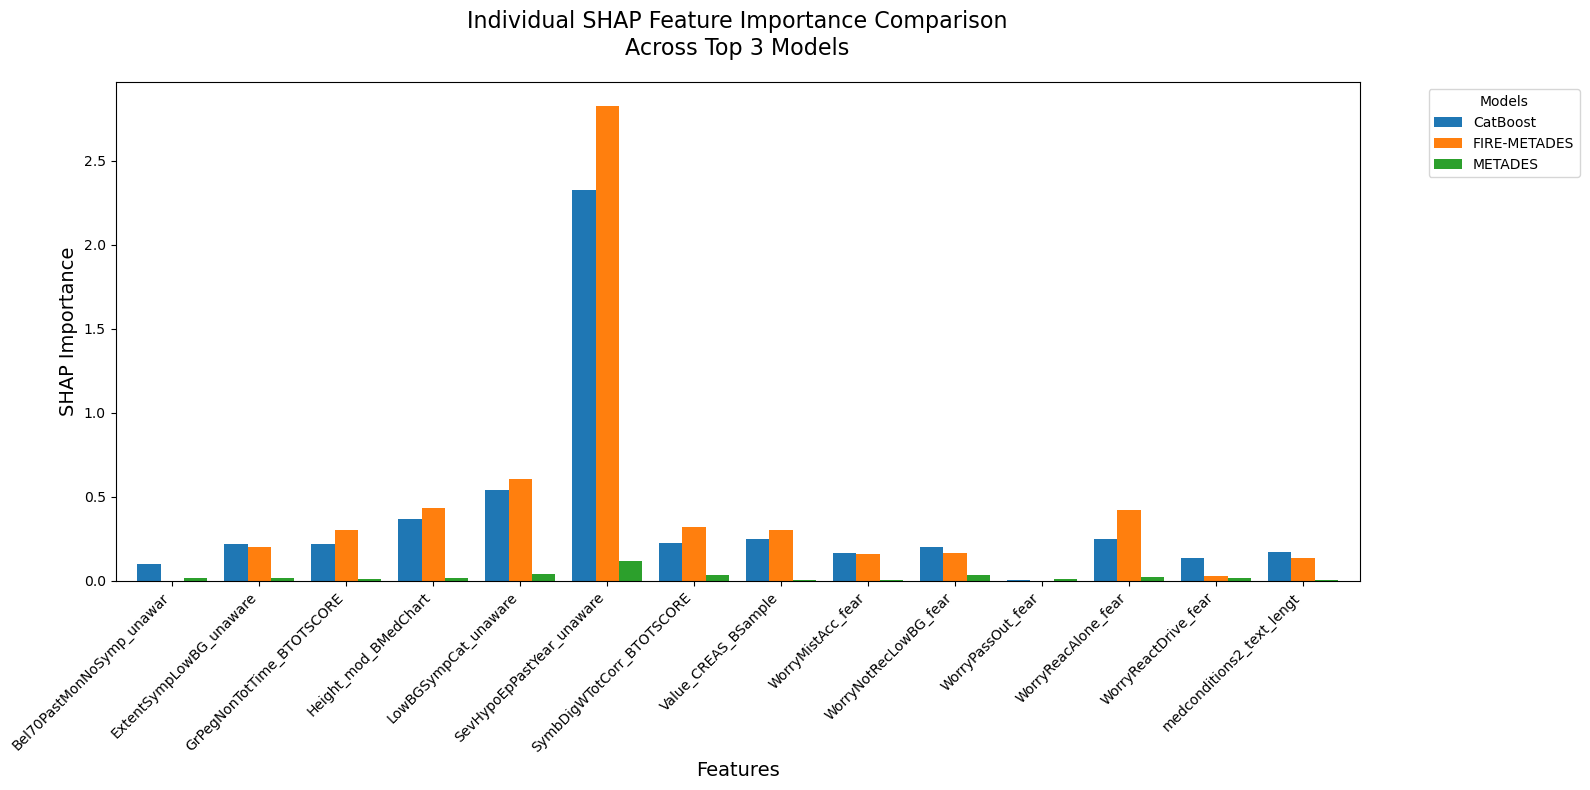


Averaged SHAP values shape: (60, 50)
Final sample size: 60
📁 Saved: averaged_shap_feature_importance.png


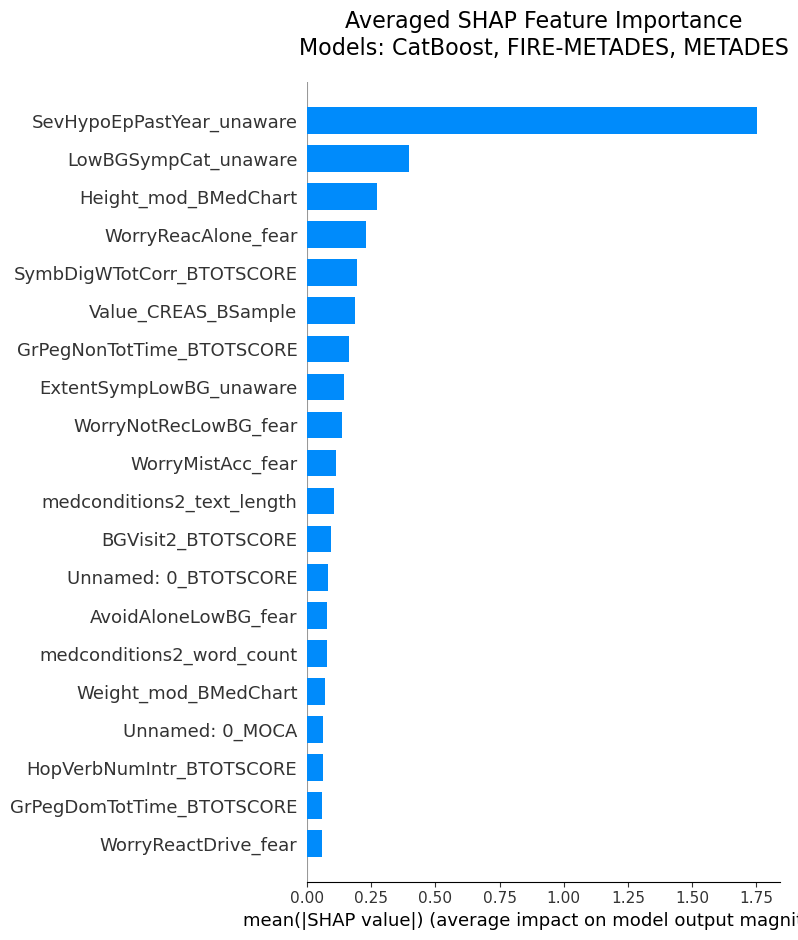


📋 COMPREHENSIVE SHAP ANALYSIS SUMMARY:

🏆 INDIVIDUAL MODEL ANALYSIS:
   1. CatBoost            : Acc=0.8067, AUC=0.8950
      Most Important Feature: SevHypoEpPastYear_unaware (2.3239)
   2. FIRE-METADES        : Acc=0.8050, AUC=0.8888
      Most Important Feature: SevHypoEpPastYear_unaware (2.8245)
   3. METADES             : Acc=0.8050, AUC=0.8863
      Most Important Feature: SevHypoEpPastYear_unaware (0.1167)

🔍 FEATURE CONSISTENCY ANALYSIS:
   Features appearing in multiple top-5 lists:
      • SevHypoEpPastYear_unaware          : 3/3 models
      • LowBGSympCat_unaware               : 3/3 models
      • Height_mod_BMedChart               : 2/3 models
      • WorryReacAlone_fear                : 3/3 models
      • SymbDigWTotCorr_BTOTSCORE          : 2/3 models

✅ Individual SHAP analysis completed successfully!
📊 Analyzed 3 models individually
📁 Generated detailed comparison visualizations
💾 All plots saved as PNG files in current directory


In [29]:
# Numpy fix for bool type
if not hasattr(np, 'bool'):
    np.bool = bool

# SHAP Analysis for Best Performing Models
if 'overall_performance' in locals() and len(overall_performance) > 0:
    print("="*60)
    print("INDIVIDUAL SHAP ANALYSIS FOR TOP 3 MODELS")
    print("="*60)
    
    # Get top 3 models from the comprehensive analysis
    top_3_models = overall_performance[:3]
    print(f"Automatically selected top 3 models for individual SHAP analysis:")
    for i, (model_name, accuracy, _, _, _, _, _, auc, _) in enumerate(top_3_models, 1):
        print(f"  {i}. {model_name:<20}: Accuracy={accuracy:.4f}, AUC={auc:.4f}")
    
    # Prepare data for SHAP analysis using the last random state configuration
    X = splitted_dataset.drop(TARGET_COLUMN, axis=1)
    y = splitted_dataset[TARGET_COLUMN]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=0
    )
    
    # Outlier removal and preprocessing (same as training)
    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)
    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]
    
    # SMOTE and scaling
    smote = SMOTE(random_state=0)
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    scaler = MinMaxScaler()
    X_res_scaled = scaler.fit_transform(X_res)
    X_test_scaled = scaler.transform(X_test)
    
    # Feature selection (top 50 features)
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
    rf_selector.fit(X_res_scaled, y_res)
    feature_importance = rf_selector.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    top_features = [X.columns[i] for i in indices[:CONFIG['TOP_FEATURES_COUNT']]]
    
    # Prepare final datasets
    X_res_final = pd.DataFrame(X_res_scaled, columns=X.columns)[top_features]
    X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)[top_features]
    
    print(f"\nData prepared for SHAP analysis:")
    print(f"Training samples: {X_res_final.shape[0]}")
    print(f"Test samples: {X_test_final.shape[0]}")
    print(f"Features: {X_res_final.shape[1]}")
    
    # Map model names to actual model classes with optimized hyperparameters
    model_mapping = {
        # Classical models
        'DT': DecisionTreeClassifier(random_state=0, criterion='gini', max_depth=6, min_samples_leaf=10, min_samples_split=9),
        'LR': LogisticRegression(random_state=0, C=0.09659168435718246, max_iter=1000, solver='lbfgs'),
        'NB': GaussianNB(var_smoothing=0.0058873326349240295),
        'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='uniform'),
        'MLP': MLPClassifier(random_state=0, max_iter=2000, alpha=0.0003079393718075164, hidden_layer_sizes=(195,), learning_rate_init=0.0001675266159417717),
        'SVC': SVC(probability=True, kernel='rbf', C=0.95, gamma='scale', random_state=0),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=0, max_depth=10, min_samples_split=5),
        'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5, random_state=0), n_estimators=50, random_state=0),
        
        # Static/Ensemble models
        'RF': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
        'XGB': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'GB': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=0),
        'AdaBoost': AdaBoostClassifier(n_estimators=200, learning_rate=0.5, algorithm='SAMME', random_state=0),
        'HistGB': HistGradientBoostingClassifier(max_iter=200, learning_rate=0.1, max_depth=5, random_state=0),
        'CatBoost': CatBoostClassifier(depth=3, iterations=168, learning_rate=0.1, verbose=0, random_state=0),
        'VotingHard': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ], voting='hard'
        ),
        'VotingSoft': VotingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=0)),
                ('xgb', XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0)),
                ('gb', GradientBoostingClassifier(n_estimators=100, random_state=0))
            ], voting='soft'
        ),
        
        # Hyperopt models (use same as static for SHAP)
        'RandomForest': RandomForestClassifier(n_estimators=143, criterion='entropy', max_depth=15, random_state=0),
        'XGBoost': XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.05, random_state=0),
        
        # DES models - we'll create base models for these
        'KNORAE': RandomForestClassifier(n_estimators=100, random_state=0),
        'KNORAU': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'DESMI': GradientBoostingClassifier(n_estimators=100, random_state=0),
        'METADES': RandomForestClassifier(n_estimators=100, random_state=0),
        'DESKNN': KNeighborsClassifier(n_neighbors=15, weights='uniform'),
        'DESP': DecisionTreeClassifier(random_state=0, max_depth=10),
        'KNOP': RandomForestClassifier(n_estimators=100, random_state=0),
        'FIRE-KNORA-U': XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=0),
        'FIRE-KNORA-E': RandomForestClassifier(n_estimators=100, random_state=0),
        'FIRE-METADES': GradientBoostingClassifier(n_estimators=100, random_state=0),
        'FIRE-DESKNN': KNeighborsClassifier(n_neighbors=15, weights='uniform'),
        'FIRE-DESP': DecisionTreeClassifier(random_state=0, max_depth=10),
        'FIRE-KNOP': RandomForestClassifier(n_estimators=100, random_state=0),
    }
    
    # Sample data for faster SHAP computation
    sample_size = min(100, X_test_final.shape[0])
    X_sample = X_test_final.sample(n=sample_size, random_state=0)
    background_size = min(50, X_res_final.shape[0])
    X_background = X_res_final.sample(n=background_size, random_state=0)
    
    print(f"Using {sample_size} test samples and {background_size} background samples")
    
    # INDIVIDUAL SHAP Analysis for each model
    individual_results = {}
    all_shap_values = []
    model_names_used = []
    
    for i, (model_name, accuracy, _, _, _, _, _, auc, _) in enumerate(top_3_models, 1):
        if model_name in model_mapping:
            try:
                print(f"\n🔄 Processing {i}. {model_name}...")
                
                # Train fresh model for this specific analysis
                model = model_mapping[model_name]
                model.fit(X_res_final, y_res)
                
                # Choose appropriate SHAP explainer based on model type
                if hasattr(model, 'tree_') or 'Forest' in str(type(model)) or 'XGB' in str(type(model)) or 'CatBoost' in str(type(model)) or 'Gradient' in str(type(model)):
                    # Tree-based models
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_sample)
                    
                    # Handle multi-class output
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                elif 'Voting' in str(type(model)):
                    # For voting classifiers, use the first estimator as proxy
                    base_model = model.estimators_[0]
                    if hasattr(base_model, 'tree_') or 'Forest' in str(type(base_model)):
                        explainer = shap.TreeExplainer(base_model)
                        shap_values = explainer.shap_values(X_sample)
                    else:
                        explainer = shap.KernelExplainer(model.predict_proba, X_background)
                        shap_values = explainer.shap_values(X_sample[:20])  # Smaller sample for kernel
                        X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                elif 'KNeighbors' in str(type(model)):
                    # For KNN, use KernelExplainer with smaller sample
                    explainer = shap.KernelExplainer(model.predict_proba, X_background)
                    shap_values = explainer.shap_values(X_sample[:20])  # Use smaller sample for kernel
                    X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                        
                else:
                    # For other models, use KernelExplainer (slower but more general)
                    explainer = shap.KernelExplainer(model.predict_proba, X_background)
                    shap_values = explainer.shap_values(X_sample[:20])  # Use smaller sample for kernel
                    X_sample_curr = X_sample[:20]  # Update sample to match
                    
                    if isinstance(shap_values, list):
                        shap_values_processed = shap_values[1] if len(shap_values) > 1 else shap_values[0]
                    else:
                        shap_values_processed = shap_values
                
                # Calculate individual feature importance for this model
                individual_importance = np.abs(shap_values_processed).mean(axis=0)
                top_feature_indices = np.argsort(individual_importance)[::-1][:10]
                
                # Store individual results
                individual_results[model_name] = {
                    'importance': individual_importance,
                    'top_indices': top_feature_indices,
                    'shap_values': shap_values_processed,
                    'accuracy': accuracy,
                    'auc': auc
                }
                
                # Store for averaging
                all_shap_values.append(shap_values_processed)
                model_names_used.append(model_name)
                
                # Display individual results immediately
                print(f"\n📊 {model_name} Individual Results:")
                print(f"   Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
                print(f"   Top 5 Most Important Features:")
                for j, feat_idx in enumerate(top_feature_indices[:5], 1):
                    feature_name = X_sample.columns[feat_idx]
                    importance = individual_importance[feat_idx]
                    print(f"      {j}. {feature_name:<35}: {importance:.4f}")
                
            except Exception as e:
                print(f"✗ Error generating SHAP explanations for {model_name}: {e}")
                continue
        else:
            print(f"⚠ Warning: Model {model_name} not found in model mapping. Skipping.")
            continue
    
    # Generate comparison visualization if we have multiple models
    if len(individual_results) >= 2:
        print(f"\n📊 Creating individual and averaged SHAP visualizations...")
        
        # 1. Individual Feature Importance Comparison
        plt.figure(figsize=(16, 10))
        
        # Get all unique features that appear in top 10 of any model
        all_important_features = set()
        for model_data in individual_results.values():
            top_features_model = [X_sample.columns[i] for i in model_data['top_indices'][:10]]
            all_important_features.update(top_features_model)
        
        all_important_features = list(all_important_features)[:15]  # Limit to top 15 overall
        
        # Create comparison data
        comparison_data = []
        for feature in all_important_features:
            feat_idx = X_sample.columns.get_loc(feature)
            for model_name, model_data in individual_results.items():
                importance = model_data['importance'][feat_idx]
                comparison_data.append({
                    'Feature': feature[:25],  # Truncate long feature names
                    'Model': model_name,
                    'Importance': importance
                })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create grouped bar plot
        pivot_df = comparison_df.pivot(index='Feature', columns='Model', values='Importance').fillna(0)
        ax = pivot_df.plot(kind='bar', figsize=(16, 8), width=0.8)
        plt.title('Individual SHAP Feature Importance Comparison\nAcross Top 3 Models', 
                 fontsize=16, pad=20)
        plt.xlabel('Features', fontsize=14)
        plt.ylabel('SHAP Importance', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        if CONFIG['SAVE_PLOTS']:
            plt.savefig('individual_shap_comparison.png', dpi=300, bbox_inches='tight')
            print("📁 Saved: individual_shap_comparison.png")
        
        plt.show()
        
        # 2. Averaged SHAP Analysis
        if len(all_shap_values) >= 2:
            # Ensure all SHAP values have the same shape
            min_samples = min([shap_vals.shape[0] for shap_vals in all_shap_values])
            X_sample_final = X_sample.iloc[:min_samples]
            
            # Truncate all SHAP values to same size and average them
            truncated_shap_values = [shap_vals[:min_samples] for shap_vals in all_shap_values]
            averaged_shap_values = np.mean(truncated_shap_values, axis=0)
            
            print(f"\nAveraged SHAP values shape: {averaged_shap_values.shape}")
            print(f"Final sample size: {min_samples}")
            
            # Averaged SHAP Feature Importance Plot
            plt.figure(figsize=(14, 8))
            shap.summary_plot(
                averaged_shap_values,
                X_sample_final,
                plot_type='bar',
                max_display=20,
                show=False
            )
            
            model_list = ", ".join(model_names_used)
            plt.title(f'Averaged SHAP Feature Importance\nModels: {model_list}', 
                     fontsize=16, pad=20)
            plt.tight_layout()
            
            if CONFIG['SAVE_PLOTS']:
                plt.savefig('averaged_shap_feature_importance.png', dpi=300, bbox_inches='tight')
                print("📁 Saved: averaged_shap_feature_importance.png")
            
            plt.show()
        
        # Summary
        print(f"\n📋 COMPREHENSIVE SHAP ANALYSIS SUMMARY:")
        print("=" * 70)
        
        print(f"\n🏆 INDIVIDUAL MODEL ANALYSIS:")
        for i, (model_name, model_data) in enumerate(individual_results.items(), 1):
            accuracy = model_data['accuracy']
            auc = model_data['auc']
            top_feature = X_sample.columns[model_data['top_indices'][0]]
            top_importance = model_data['importance'][model_data['top_indices'][0]]
            
            print(f"   {i}. {model_name:<20}: Acc={accuracy:.4f}, AUC={auc:.4f}")
            print(f"      Most Important Feature: {top_feature} ({top_importance:.4f})")
        
        # Feature consistency analysis
        print(f"\n🔍 FEATURE CONSISTENCY ANALYSIS:")
        top_features_by_model = {}
        for model_name, model_data in individual_results.items():
            top_features_by_model[model_name] = [X_sample.columns[i] for i in model_data['top_indices'][:5]]
        
        # Find features that appear in top 5 of multiple models
        all_top_features = []
        for features in top_features_by_model.values():
            all_top_features.extend(features)
        
        from collections import Counter
        feature_counts = Counter(all_top_features)
        consistent_features = [feat for feat, count in feature_counts.items() if count > 1]
        
        if consistent_features:
            print(f"   Features appearing in multiple top-5 lists:")
            for feature in consistent_features:
                count = feature_counts[feature]
                print(f"      • {feature:<35}: {count}/{len(individual_results)} models")
        else:
            print(f"   No features appear consistently across models (indicates model diversity)")
        
        print(f"\n✅ Individual SHAP analysis completed successfully!")
        print(f"📊 Analyzed {len(individual_results)} models individually")
        print(f"📁 Generated detailed comparison visualizations")
        if CONFIG['SAVE_PLOTS']:
            print(f"💾 All plots saved as PNG files in current directory")
    
    else:
        print("⚠️ Not enough models successfully analyzed for comparison.")
        
else:
    print("⚠️ No comprehensive analysis results available for SHAP analysis.")
    print("Please run the complete training pipeline first to generate 'overall_performance' rankings.")